In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import random
from torchvision.models.resnet import resnet18

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
EXPERIMENT_NAME = 'GAN-ResNet'
RESULT_DIR = Path('results')
dirs = []
for f in RESULT_DIR.iterdir():
    if not f.is_dir() or len(f.name) < 6 or not str.isdigit(f.name[:4]):
        continue
    dirs.append(f)
dirs = sorted(dirs)
experiment_number = int(dirs[-1].name[:4]) + 1 if dirs else 0

EXPERIMENT_DIR = RESULT_DIR / f'{experiment_number:04d}-{EXPERIMENT_NAME}'
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)
print('Experiment path:', EXPERIMENT_DIR)

DATA_DIR = Path('data/1116')

Experiment path: results/0046-GAN-ResNet


# Create Dataset

In [4]:
def load_result(checkpoint_dir):
    d = Path(checkpoint_dir)
    X = np.load(d / 'result-X.npy')
    Y = np.load(d / 'result-Y.npy')
    P = np.load(d / 'result-P.npy')
    return X, Y, P

In [5]:
X, Y, P = load_result('checkpoint/1130-Scene3-CLSTMC4-X60')

In [6]:
X.shape, Y.shape, P.shape

((54167, 60, 6), (54167, 3), (54167, 3))

In [7]:
class DetectorDataset(Dataset):
    def __init__(self, Y, P, L):
        super(DetectorDataset, self).__init__()

        self.Y = torch.tensor(Y, dtype=torch.float32).transpose(0, 1)
        self.P = torch.tensor(P, dtype=torch.float32).transpose(0, 1)
        self.L = L
        self.dssize = self.Y.shape[1] // self.L
        
        self.means = torch.stack([self.Y[0].mean(), self.Y[1].mean(), self.Y[2].mean()]).unsqueeze(1)
        self.stds = torch.stack([self.Y[0].std(), self.Y[1].std(), self.Y[2].std()]).unsqueeze(1)
        self.Y = (self.Y - self.means) / self.stds
        self.P = (self.P - self.means) / self.stds

    def __len__(self):
        return self.dssize

    def __getitem__(self, idx):
        x = self.Y[:, idx:idx + self.L]
        x_ = self.P[:, idx:idx + self.L]
        return x, x_

In [8]:
ds = DetectorDataset(Y, P, 120)

# Create Model

## Model Common Parts

In [9]:
class ResBlock1d(nn.Module):
    expansion = 1
    
    def __init__(self, inchannels, channels, kernel_size, stride=1, groups=1):
        super(ResBlock1d, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(inchannels, channels, kernel_size, padding=kernel_size // 2, stride=stride, groups=groups, padding_mode='replicate'),
            nn.BatchNorm1d(channels),
            nn.LeakyReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, groups=groups, padding_mode='replicate'),
            nn.BatchNorm1d(channels)
        )
        self.act = nn.LeakyReLU()
        
        self.conv2 = None
        if inchannels != channels:
            self.conv2 = nn.Sequential(
                nn.Conv1d(inchannels, channels, 1, stride=stride, groups=groups),
                nn.BatchNorm1d(channels)
            )

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        if self.conv2 is not None:
            identity = self.conv2(identity)
        x += identity
        x = self.act(x)

        return x

## D Model - Resnet15 1d

In [10]:
class ConvDetector(nn.Module):
    def __init__(self, block, layers):
        super(ConvDetector, self).__init__()
        
        self.inchannels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(3, self.inchannels, 7, stride=2, padding=3, bias=False, padding_mode='replicate'),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.sigmoid(x)

        return x
    
    def _make_layer(self, block, channels, blocks, stride=1):
        layers = []
        layers.append(block(self.inchannels, channels, 3))
        self.inchannels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inchannels, channels, 3))
        
        return nn.Sequential(*layers)

## G Model - Conv Layer

In [11]:
class GModel(nn.Module):
    def __init__(self):
        super(GModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(3, 64, 3, padding=1, padding_mode='replicate'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            ResBlock1d(64, 64, 3),
            ResBlock1d(64, 128, 3),
            ResBlock1d(128, 128, 3),
            ResBlock1d(128, 256, 3),
            ResBlock1d(256, 256, 3),
            ResBlock1d(256, 512, 3),
            ResBlock1d(512, 512, 3),
            nn.Conv1d(512, 3, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

## Create Model

In [32]:
D = ConvDetector(ResBlock1d, [2, 2, 2, 2]).cuda()

In [33]:
G = GModel().cuda()

## Create Loss, Optimizer

In [34]:
d_criterion = nn.BCELoss().cuda()
g_criterion = nn.MSELoss().cuda()

In [35]:
d_optimizer = torch.optim.Adam(D.parameters())
g_optimizer = torch.optim.Adam(G.parameters())

# Training

In [36]:
valid_size = int(len(ds) * 0.2)
ds_train, ds_test = random_split(ds, [len(ds) - valid_size, valid_size])

In [37]:
dssize = len(ds_test)
dstestsize = dssize // 2
ds_test, ds_test2 = random_split(ds_test, [dstestsize, dssize - dstestsize])

In [38]:
len(ds_train), len(ds_test), len(ds_test2)

(361, 45, 45)

In [39]:
dl_train = DataLoader(ds, batch_size=256, num_workers=2, pin_memory=True, shuffle=True)
dl_test  = DataLoader(ds_test,  batch_size=256, num_workers=2, pin_memory=True, shuffle=True)

In [40]:
def plot_result():
    X = np.linspace(0, x_real.shape[-1] / 60, x_real.shape[-1])

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    #plt.plot(X, (x_real[12, 0, :].detach().cpu()))
    #plt.plot(X, (x_fake[12, 0, :].detach().cpu()))
    #plt.plot(X, (x_gen[12, 0, :].detach().cpu()))
    plt.plot(X, (x_real[12, 0, :].detach().cpu() * ds.stds[0]) + ds.means[0])
    plt.plot(X, (x_fake[12, 0, :].detach().cpu() * ds.stds[0]) + ds.means[0])
    plt.plot(X, (x_gen[12, 0, :].detach().cpu() * ds.stds[0]) + ds.means[0])
    plt.title('Yaw')
    plt.legend(['Real', 'Input', 'Fake'])
    plt.ylabel('Degree')
    plt.xlabel('Time (sec)')

    plt.subplot(1, 3, 2)
    #plt.plot(X, (x_real[12, 1, :].detach().cpu()))
    #plt.plot(X, (x_fake[12, 1, :].detach().cpu()))
    #plt.plot(X, (x_gen[12, 1, :].detach().cpu()))
    plt.plot(X, (x_real[12, 1, :].detach().cpu() * ds.stds[1]) + ds.means[1])
    plt.plot(X, (x_fake[12, 1, :].detach().cpu() * ds.stds[1]) + ds.means[1])
    plt.plot(X, (x_gen[12, 1, :].detach().cpu() * ds.stds[1]) + ds.means[1])
    plt.title('Pitch')
    plt.legend(['Real', 'Input', 'Fake'])
    plt.ylabel('Degree')
    plt.xlabel('Time (sec)')

    plt.subplot(1, 3, 3)
    #plt.plot(X, (x_real[12, 2, :].detach().cpu()))
    #plt.plot(X, (x_fake[12, 2, :].detach().cpu()))
    #plt.plot(X, (x_gen[12, 2, :].detach().cpu()))
    plt.plot(X, (x_real[12, 2, :].detach().cpu() * ds.stds[2]) + ds.means[2])
    plt.plot(X, (x_fake[12, 2, :].detach().cpu() * ds.stds[2]) + ds.means[2])
    plt.plot(X, (x_gen[12, 2, :].detach().cpu() * ds.stds[2]) + ds.means[2])
    plt.title('Roll')
    plt.legend(['Real', 'Input', 'Fake'])
    plt.ylabel('Degree')
    plt.xlabel('Time (sec)')

    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / f'GAN-epoch{epoch:03d}.png')
    plt.show()

Train Epoch[001/1000] Step [02/02] d_loss: 3.0026, d_loss_real: 1.6888, d_loss_fake: 0.8671 g_loss: 1.3414 acc_real: 0.4872 acc_fake: 0.5385
Validation Epoch[001/1000] Step [01/01] d_loss: 1.3947, d_loss_real: 0.7603, d_loss_fake: 0.6345 g_loss: 0.6228 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[002/1000] Step [02/02] d_loss: 2.1284, d_loss_real: 0.9763, d_loss_fake: 0.8498 g_loss: 1.5988 acc_real: 0.5282 acc_fake: 0.4615
Validation Epoch[002/1000] Step [01/01] d_loss: 1.3769, d_loss_real: 0.6462, d_loss_fake: 0.7307 g_loss: 0.6930 acc_real: 1.0000 acc_fake: 0.0000
Train Epoch[003/1000] Step [02/02] d_loss: 1.3067, d_loss_real: 0.4613, d_loss_fake: 0.5614 g_loss: 0.7874 acc_real: 0.8256 acc_fake: 0.3846
Validation Epoch[003/1000] Step [01/01] d_loss: 2.0612, d_loss_real: 1.8632, d_loss_fake: 0.1980 g_loss: 0.2533 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[004/1000] Step [02/02] d_loss: 0.6761, d_loss_real: 0.2762, d_loss_fake: 0.2403 g_loss: 0.3668 acc_real: 1.0000 acc_fake: 0.887

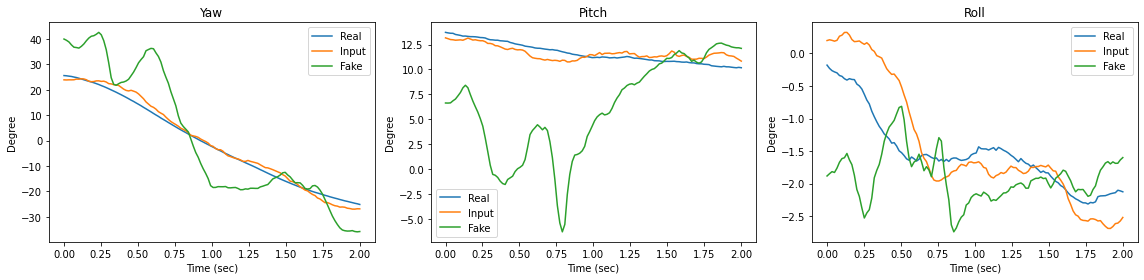

Train Epoch[011/1000] Step [02/02] d_loss: 0.0574, d_loss_real: 0.0369, d_loss_fake: 0.0186 g_loss: 0.0259 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[011/1000] Step [01/01] d_loss: 1.7308, d_loss_real: 1.5088, d_loss_fake: 0.2221 g_loss: 0.2181 acc_real: 0.1556 acc_fake: 1.0000
Train Epoch[012/1000] Step [02/02] d_loss: 0.0468, d_loss_real: 0.0292, d_loss_fake: 0.0154 g_loss: 0.0201 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[012/1000] Step [01/01] d_loss: 1.5832, d_loss_real: 1.4574, d_loss_fake: 0.1258 g_loss: 0.1262 acc_real: 0.1556 acc_fake: 1.0000
Train Epoch[013/1000] Step [02/02] d_loss: 0.0417, d_loss_real: 0.0258, d_loss_fake: 0.0137 g_loss: 0.0176 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[013/1000] Step [01/01] d_loss: 1.4235, d_loss_real: 1.3310, d_loss_fake: 0.0925 g_loss: 0.0928 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[014/1000] Step [02/02] d_loss: 0.0342, d_loss_real: 0.0217, d_loss_fake: 0.0114 g_loss: 0.0150 acc_real: 1.0000 acc_fake: 1.000

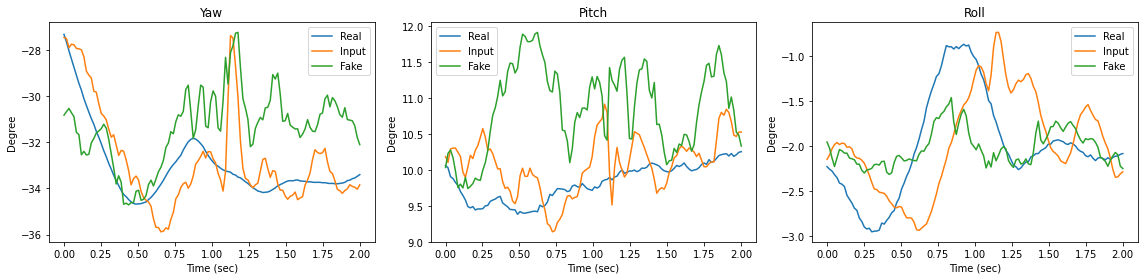

Train Epoch[021/1000] Step [02/02] d_loss: 0.0140, d_loss_real: 0.0076, d_loss_fake: 0.0061 g_loss: 0.0081 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[021/1000] Step [01/01] d_loss: 0.5788, d_loss_real: 0.5292, d_loss_fake: 0.0496 g_loss: 0.0477 acc_real: 0.6222 acc_fake: 1.0000
Train Epoch[022/1000] Step [02/02] d_loss: 0.0141, d_loss_real: 0.0079, d_loss_fake: 0.0058 g_loss: 0.0081 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[022/1000] Step [01/01] d_loss: 0.5736, d_loss_real: 0.5270, d_loss_fake: 0.0466 g_loss: 0.0447 acc_real: 0.6444 acc_fake: 1.0000
Train Epoch[023/1000] Step [02/02] d_loss: 0.0121, d_loss_real: 0.0068, d_loss_fake: 0.0051 g_loss: 0.0071 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[023/1000] Step [01/01] d_loss: 0.6461, d_loss_real: 0.6029, d_loss_fake: 0.0431 g_loss: 0.0412 acc_real: 0.5778 acc_fake: 1.0000
Train Epoch[024/1000] Step [02/02] d_loss: 0.0115, d_loss_real: 0.0063, d_loss_fake: 0.0049 g_loss: 0.0069 acc_real: 1.0000 acc_fake: 1.000

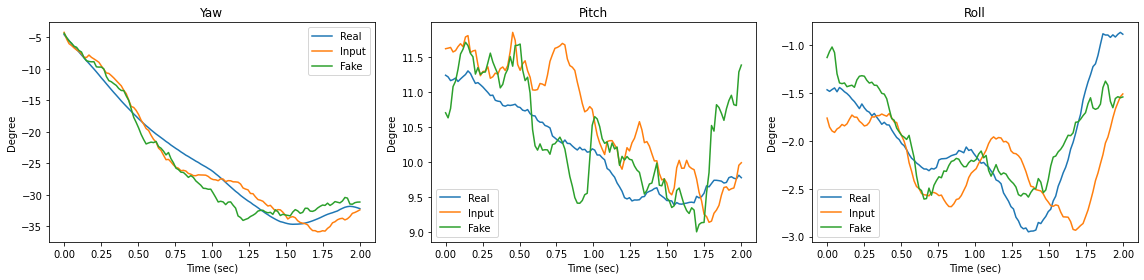

Train Epoch[031/1000] Step [02/02] d_loss: 0.0070, d_loss_real: 0.0039, d_loss_fake: 0.0030 g_loss: 0.0042 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[031/1000] Step [01/01] d_loss: 1.0322, d_loss_real: 1.0019, d_loss_fake: 0.0303 g_loss: 0.0286 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[032/1000] Step [02/02] d_loss: 0.0062, d_loss_real: 0.0035, d_loss_fake: 0.0026 g_loss: 0.0036 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[032/1000] Step [01/01] d_loss: 1.0627, d_loss_real: 1.0336, d_loss_fake: 0.0291 g_loss: 0.0273 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[033/1000] Step [02/02] d_loss: 0.0063, d_loss_real: 0.0035, d_loss_fake: 0.0027 g_loss: 0.0034 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[033/1000] Step [01/01] d_loss: 1.0403, d_loss_real: 1.0107, d_loss_fake: 0.0297 g_loss: 0.0276 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[034/1000] Step [02/02] d_loss: 0.0057, d_loss_real: 0.0033, d_loss_fake: 0.0024 g_loss: 0.0031 acc_real: 1.0000 acc_fake: 1.000

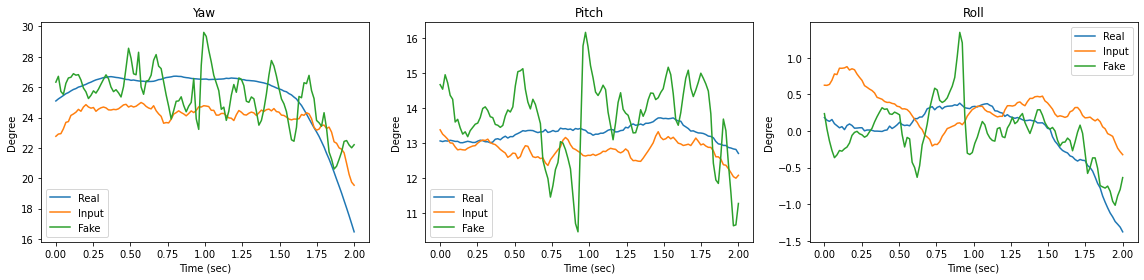

Train Epoch[041/1000] Step [02/02] d_loss: 0.0050, d_loss_real: 0.0029, d_loss_fake: 0.0020 g_loss: 0.0025 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[041/1000] Step [01/01] d_loss: 1.1696, d_loss_real: 1.1477, d_loss_fake: 0.0219 g_loss: 0.0204 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[042/1000] Step [02/02] d_loss: 0.0045, d_loss_real: 0.0027, d_loss_fake: 0.0018 g_loss: 0.0022 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[042/1000] Step [01/01] d_loss: 1.1929, d_loss_real: 1.1731, d_loss_fake: 0.0198 g_loss: 0.0184 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[043/1000] Step [02/02] d_loss: 0.0044, d_loss_real: 0.0026, d_loss_fake: 0.0018 g_loss: 0.0025 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[043/1000] Step [01/01] d_loss: 1.2004, d_loss_real: 1.1806, d_loss_fake: 0.0198 g_loss: 0.0184 acc_real: 0.5111 acc_fake: 1.0000
Train Epoch[044/1000] Step [02/02] d_loss: 0.0040, d_loss_real: 0.0024, d_loss_fake: 0.0016 g_loss: 0.0020 acc_real: 1.0000 acc_fake: 1.000

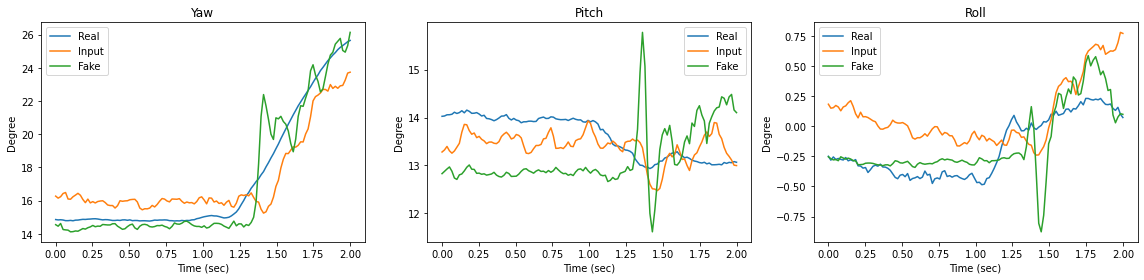

Train Epoch[051/1000] Step [02/02] d_loss: 0.0034, d_loss_real: 0.0020, d_loss_fake: 0.0014 g_loss: 0.0020 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[051/1000] Step [01/01] d_loss: 1.2330, d_loss_real: 1.2152, d_loss_fake: 0.0178 g_loss: 0.0165 acc_real: 0.5111 acc_fake: 1.0000
Train Epoch[052/1000] Step [02/02] d_loss: 0.0033, d_loss_real: 0.0019, d_loss_fake: 0.0013 g_loss: 0.0017 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[052/1000] Step [01/01] d_loss: 1.2503, d_loss_real: 1.2329, d_loss_fake: 0.0174 g_loss: 0.0161 acc_real: 0.5111 acc_fake: 1.0000
Train Epoch[053/1000] Step [02/02] d_loss: 0.0039, d_loss_real: 0.0020, d_loss_fake: 0.0017 g_loss: 0.0020 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[053/1000] Step [01/01] d_loss: 1.2086, d_loss_real: 1.1929, d_loss_fake: 0.0157 g_loss: 0.0147 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[054/1000] Step [02/02] d_loss: 0.0032, d_loss_real: 0.0018, d_loss_fake: 0.0013 g_loss: 0.0021 acc_real: 1.0000 acc_fake: 1.000

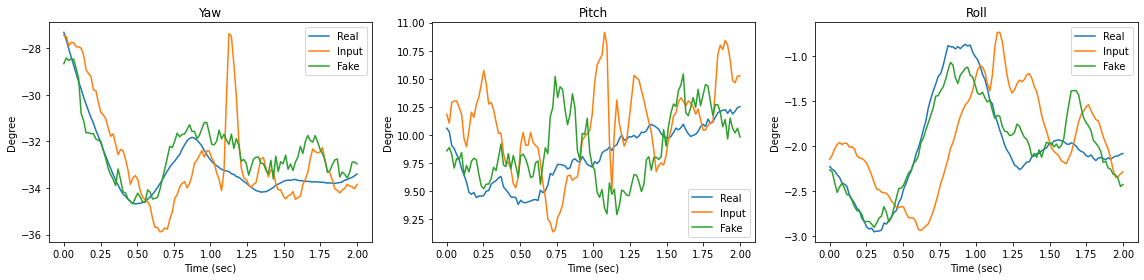

Train Epoch[061/1000] Step [02/02] d_loss: 0.0028, d_loss_real: 0.0017, d_loss_fake: 0.0011 g_loss: 0.0016 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[061/1000] Step [01/01] d_loss: 1.3821, d_loss_real: 1.3685, d_loss_fake: 0.0136 g_loss: 0.0127 acc_real: 0.4667 acc_fake: 1.0000
Train Epoch[062/1000] Step [02/02] d_loss: 0.0025, d_loss_real: 0.0015, d_loss_fake: 0.0010 g_loss: 0.0014 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[062/1000] Step [01/01] d_loss: 1.4314, d_loss_real: 1.4174, d_loss_fake: 0.0140 g_loss: 0.0130 acc_real: 0.4667 acc_fake: 1.0000
Train Epoch[063/1000] Step [02/02] d_loss: 0.0025, d_loss_real: 0.0014, d_loss_fake: 0.0010 g_loss: 0.0013 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[063/1000] Step [01/01] d_loss: 1.3878, d_loss_real: 1.3722, d_loss_fake: 0.0156 g_loss: 0.0144 acc_real: 0.4667 acc_fake: 1.0000
Train Epoch[064/1000] Step [02/02] d_loss: 0.0024, d_loss_real: 0.0014, d_loss_fake: 0.0009 g_loss: 0.0013 acc_real: 1.0000 acc_fake: 1.000

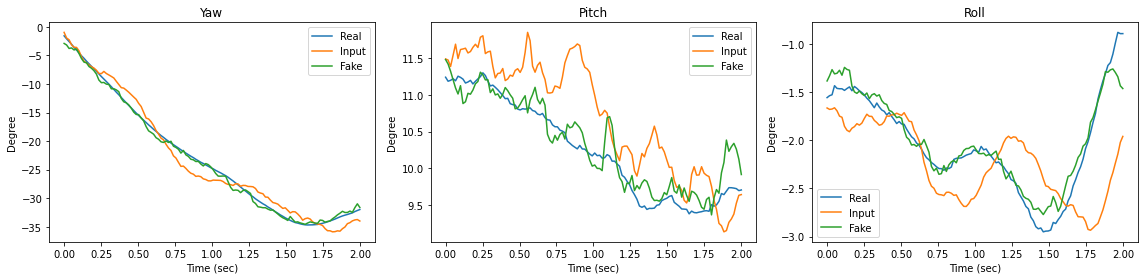

Train Epoch[071/1000] Step [02/02] d_loss: 0.0023, d_loss_real: 0.0013, d_loss_fake: 0.0010 g_loss: 0.0017 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[071/1000] Step [01/01] d_loss: 1.1466, d_loss_real: 1.1293, d_loss_fake: 0.0173 g_loss: 0.0162 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[072/1000] Step [02/02] d_loss: 0.0022, d_loss_real: 0.0012, d_loss_fake: 0.0009 g_loss: 0.0016 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[072/1000] Step [01/01] d_loss: 1.1678, d_loss_real: 1.1488, d_loss_fake: 0.0190 g_loss: 0.0179 acc_real: 0.5111 acc_fake: 1.0000
Train Epoch[073/1000] Step [02/02] d_loss: 0.0025, d_loss_real: 0.0013, d_loss_fake: 0.0010 g_loss: 0.0017 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[073/1000] Step [01/01] d_loss: 1.2477, d_loss_real: 1.2325, d_loss_fake: 0.0151 g_loss: 0.0142 acc_real: 0.4444 acc_fake: 1.0000
Train Epoch[074/1000] Step [02/02] d_loss: 0.0020, d_loss_real: 0.0012, d_loss_fake: 0.0008 g_loss: 0.0014 acc_real: 1.0000 acc_fake: 1.000

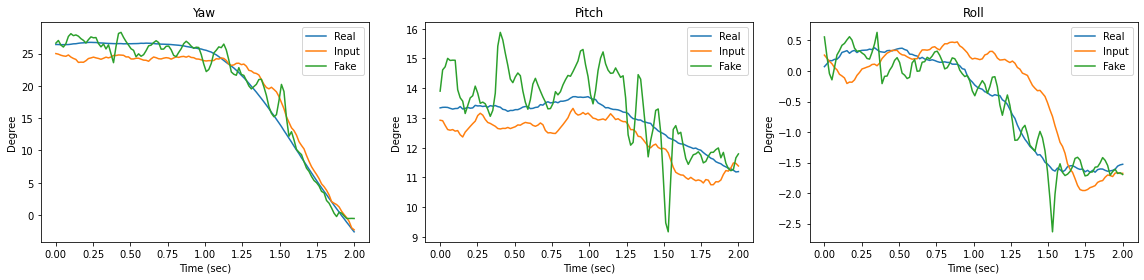

Train Epoch[081/1000] Step [02/02] d_loss: 0.0018, d_loss_real: 0.0010, d_loss_fake: 0.0007 g_loss: 0.0010 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[081/1000] Step [01/01] d_loss: 1.4235, d_loss_real: 1.4085, d_loss_fake: 0.0149 g_loss: 0.0138 acc_real: 0.4667 acc_fake: 1.0000
Train Epoch[082/1000] Step [02/02] d_loss: 0.0018, d_loss_real: 0.0010, d_loss_fake: 0.0007 g_loss: 0.0010 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[082/1000] Step [01/01] d_loss: 1.3617, d_loss_real: 1.3487, d_loss_fake: 0.0130 g_loss: 0.0121 acc_real: 0.5111 acc_fake: 1.0000
Train Epoch[083/1000] Step [02/02] d_loss: 0.0019, d_loss_real: 0.0012, d_loss_fake: 0.0007 g_loss: 0.0013 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[083/1000] Step [01/01] d_loss: 1.4110, d_loss_real: 1.3999, d_loss_fake: 0.0111 g_loss: 0.0104 acc_real: 0.5111 acc_fake: 1.0000
Train Epoch[084/1000] Step [02/02] d_loss: 0.0017, d_loss_real: 0.0010, d_loss_fake: 0.0007 g_loss: 0.0010 acc_real: 1.0000 acc_fake: 1.000

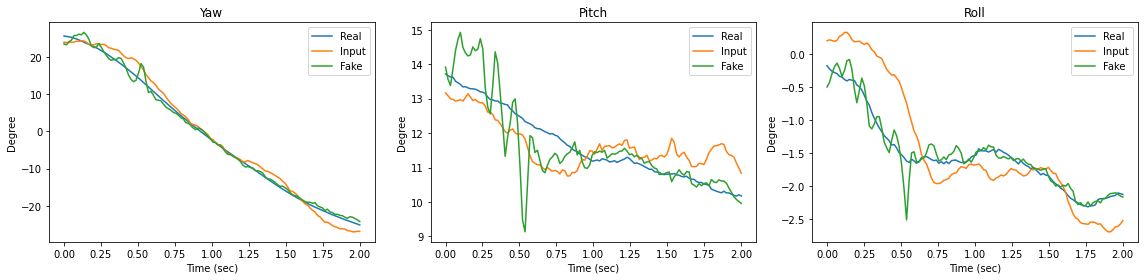

Train Epoch[091/1000] Step [02/02] d_loss: 0.0016, d_loss_real: 0.0010, d_loss_fake: 0.0007 g_loss: 0.0010 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[091/1000] Step [01/01] d_loss: 1.9056, d_loss_real: 1.8947, d_loss_fake: 0.0110 g_loss: 0.0102 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[092/1000] Step [02/02] d_loss: 0.0017, d_loss_real: 0.0008, d_loss_fake: 0.0009 g_loss: 0.0011 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[092/1000] Step [01/01] d_loss: 1.5840, d_loss_real: 1.5740, d_loss_fake: 0.0100 g_loss: 0.0094 acc_real: 0.4222 acc_fake: 1.0000
Train Epoch[093/1000] Step [02/02] d_loss: 0.0017, d_loss_real: 0.0009, d_loss_fake: 0.0007 g_loss: 0.0016 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[093/1000] Step [01/01] d_loss: 2.1858, d_loss_real: 2.1777, d_loss_fake: 0.0081 g_loss: 0.0080 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[094/1000] Step [02/02] d_loss: 0.0015, d_loss_real: 0.0009, d_loss_fake: 0.0006 g_loss: 0.0013 acc_real: 1.0000 acc_fake: 1.000

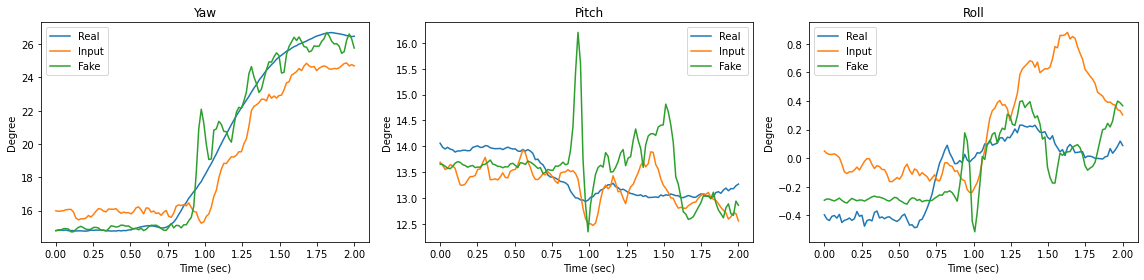

Train Epoch[101/1000] Step [02/02] d_loss: 0.0014, d_loss_real: 0.0008, d_loss_fake: 0.0006 g_loss: 0.0008 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[101/1000] Step [01/01] d_loss: 1.8509, d_loss_real: 1.8414, d_loss_fake: 0.0095 g_loss: 0.0088 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[102/1000] Step [02/02] d_loss: 0.0012, d_loss_real: 0.0007, d_loss_fake: 0.0005 g_loss: 0.0008 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[102/1000] Step [01/01] d_loss: 2.0350, d_loss_real: 2.0265, d_loss_fake: 0.0085 g_loss: 0.0080 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[103/1000] Step [02/02] d_loss: 0.0014, d_loss_real: 0.0008, d_loss_fake: 0.0006 g_loss: 0.0010 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[103/1000] Step [01/01] d_loss: 2.1745, d_loss_real: 2.1656, d_loss_fake: 0.0089 g_loss: 0.0083 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[104/1000] Step [02/02] d_loss: 0.0012, d_loss_real: 0.0007, d_loss_fake: 0.0005 g_loss: 0.0007 acc_real: 1.0000 acc_fake: 1.000

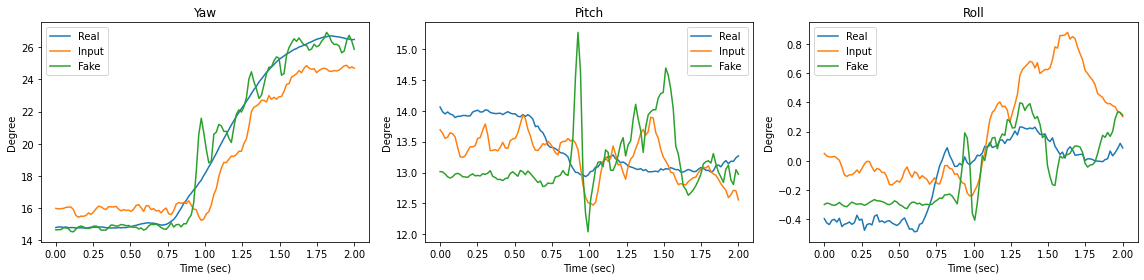

Train Epoch[111/1000] Step [02/02] d_loss: 0.0014, d_loss_real: 0.0009, d_loss_fake: 0.0005 g_loss: 0.0009 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[111/1000] Step [01/01] d_loss: 2.4192, d_loss_real: 2.4124, d_loss_fake: 0.0068 g_loss: 0.0064 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[112/1000] Step [02/02] d_loss: 0.0012, d_loss_real: 0.0007, d_loss_fake: 0.0005 g_loss: 0.0007 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[112/1000] Step [01/01] d_loss: 2.3511, d_loss_real: 2.3435, d_loss_fake: 0.0076 g_loss: 0.0070 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[113/1000] Step [02/02] d_loss: 0.0012, d_loss_real: 0.0007, d_loss_fake: 0.0005 g_loss: 0.0007 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[113/1000] Step [01/01] d_loss: 1.9388, d_loss_real: 1.9288, d_loss_fake: 0.0101 g_loss: 0.0093 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[114/1000] Step [02/02] d_loss: 0.0010, d_loss_real: 0.0006, d_loss_fake: 0.0004 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.000

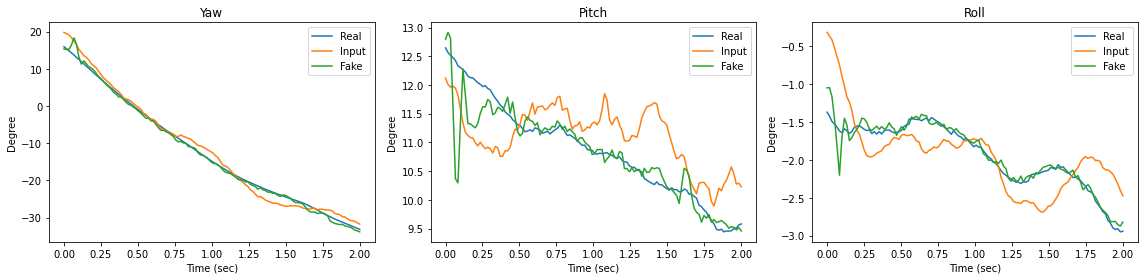

Train Epoch[121/1000] Step [02/02] d_loss: 0.0010, d_loss_real: 0.0006, d_loss_fake: 0.0004 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[121/1000] Step [01/01] d_loss: 1.7374, d_loss_real: 1.7281, d_loss_fake: 0.0093 g_loss: 0.0085 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[122/1000] Step [02/02] d_loss: 0.0009, d_loss_real: 0.0006, d_loss_fake: 0.0004 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[122/1000] Step [01/01] d_loss: 1.7741, d_loss_real: 1.7654, d_loss_fake: 0.0087 g_loss: 0.0080 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[123/1000] Step [02/02] d_loss: 0.0010, d_loss_real: 0.0006, d_loss_fake: 0.0004 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[123/1000] Step [01/01] d_loss: 1.7199, d_loss_real: 1.7117, d_loss_fake: 0.0082 g_loss: 0.0076 acc_real: 0.2222 acc_fake: 1.0000
Train Epoch[124/1000] Step [02/02] d_loss: 0.0010, d_loss_real: 0.0006, d_loss_fake: 0.0004 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.000

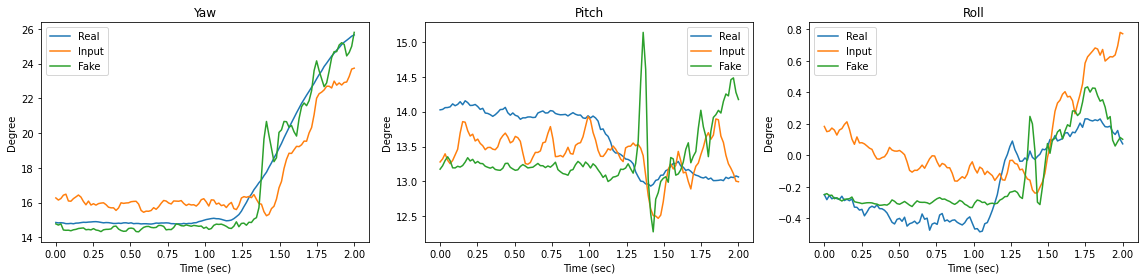

Train Epoch[131/1000] Step [02/02] d_loss: 0.0009, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[131/1000] Step [01/01] d_loss: 1.4996, d_loss_real: 1.4914, d_loss_fake: 0.0083 g_loss: 0.0076 acc_real: 0.4667 acc_fake: 1.0000
Train Epoch[132/1000] Step [02/02] d_loss: 0.0009, d_loss_real: 0.0006, d_loss_fake: 0.0004 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[132/1000] Step [01/01] d_loss: 1.4527, d_loss_real: 1.4425, d_loss_fake: 0.0102 g_loss: 0.0094 acc_real: 0.4889 acc_fake: 1.0000
Train Epoch[133/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0005, d_loss_fake: 0.0003 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[133/1000] Step [01/01] d_loss: 1.3587, d_loss_real: 1.3480, d_loss_fake: 0.0106 g_loss: 0.0097 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[134/1000] Step [02/02] d_loss: 0.0009, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0007 acc_real: 1.0000 acc_fake: 1.000

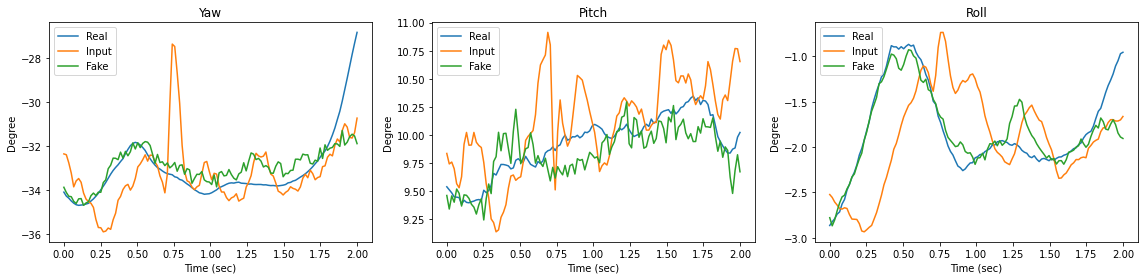

Train Epoch[141/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0005, d_loss_fake: 0.0003 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[141/1000] Step [01/01] d_loss: 2.0808, d_loss_real: 2.0733, d_loss_fake: 0.0075 g_loss: 0.0069 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[142/1000] Step [02/02] d_loss: 0.0009, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[142/1000] Step [01/01] d_loss: 1.9334, d_loss_real: 1.9257, d_loss_fake: 0.0078 g_loss: 0.0071 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[143/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[143/1000] Step [01/01] d_loss: 1.8834, d_loss_real: 1.8760, d_loss_fake: 0.0074 g_loss: 0.0068 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[144/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0005, d_loss_fake: 0.0003 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.000

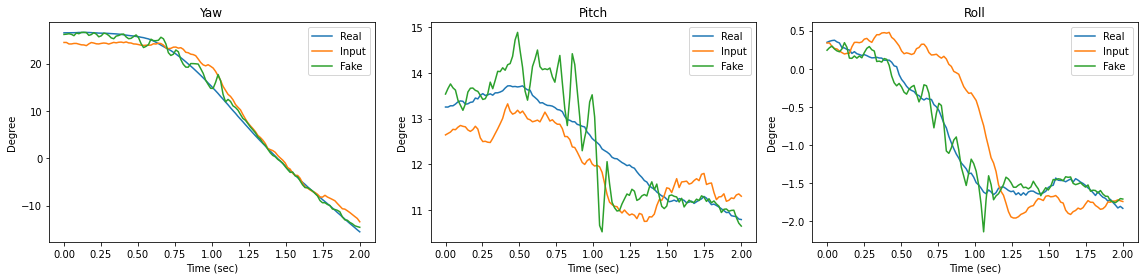

Train Epoch[151/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[151/1000] Step [01/01] d_loss: 2.2014, d_loss_real: 2.1899, d_loss_fake: 0.0116 g_loss: 0.0105 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[152/1000] Step [02/02] d_loss: 0.0022, d_loss_real: 0.0005, d_loss_fake: 0.0006 g_loss: 0.0010 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[152/1000] Step [01/01] d_loss: 2.4091, d_loss_real: 2.4029, d_loss_fake: 0.0062 g_loss: 0.0059 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[153/1000] Step [02/02] d_loss: 0.0023, d_loss_real: 0.0018, d_loss_fake: 0.0004 g_loss: 0.0012 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[153/1000] Step [01/01] d_loss: 2.5266, d_loss_real: 2.5212, d_loss_fake: 0.0054 g_loss: 0.0056 acc_real: 0.2000 acc_fake: 1.0000
Train Epoch[154/1000] Step [02/02] d_loss: 0.0007, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0012 acc_real: 1.0000 acc_fake: 1.000

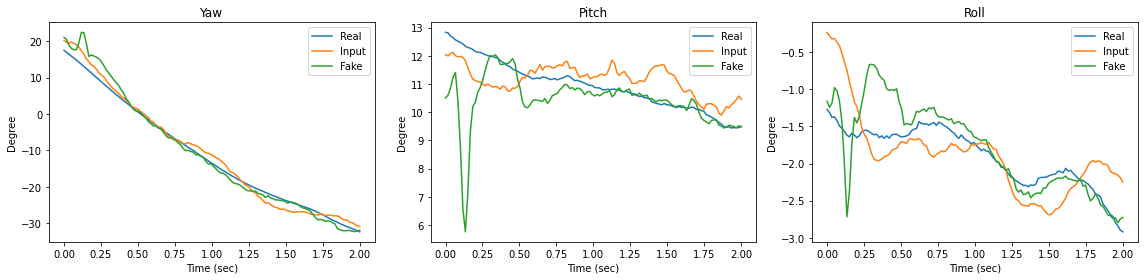

Train Epoch[161/1000] Step [02/02] d_loss: 0.0011, d_loss_real: 0.0005, d_loss_fake: 0.0006 g_loss: 0.0014 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[161/1000] Step [01/01] d_loss: 0.7666, d_loss_real: 0.7379, d_loss_fake: 0.0287 g_loss: 0.0266 acc_real: 0.6000 acc_fake: 1.0000
Train Epoch[162/1000] Step [02/02] d_loss: 0.0010, d_loss_real: 0.0005, d_loss_fake: 0.0005 g_loss: 0.0014 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[162/1000] Step [01/01] d_loss: 0.8913, d_loss_real: 0.8669, d_loss_fake: 0.0244 g_loss: 0.0230 acc_real: 0.5778 acc_fake: 1.0000
Train Epoch[163/1000] Step [02/02] d_loss: 0.0007, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0011 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[163/1000] Step [01/01] d_loss: 1.1461, d_loss_real: 1.1239, d_loss_fake: 0.0222 g_loss: 0.0206 acc_real: 0.4889 acc_fake: 1.0000
Train Epoch[164/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0010 acc_real: 1.0000 acc_fake: 1.000

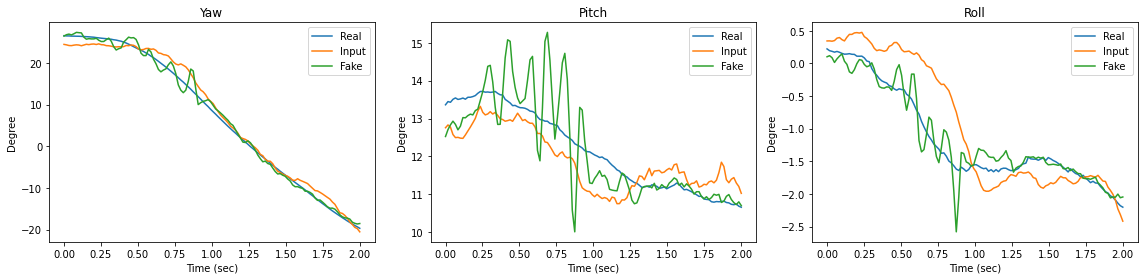

Train Epoch[171/1000] Step [02/02] d_loss: 0.0007, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[171/1000] Step [01/01] d_loss: 1.3757, d_loss_real: 1.3601, d_loss_fake: 0.0155 g_loss: 0.0143 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[172/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[172/1000] Step [01/01] d_loss: 1.3333, d_loss_real: 1.3200, d_loss_fake: 0.0133 g_loss: 0.0123 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[173/1000] Step [02/02] d_loss: 0.0007, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0007 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[173/1000] Step [01/01] d_loss: 1.4317, d_loss_real: 1.4206, d_loss_fake: 0.0111 g_loss: 0.0103 acc_real: 0.5333 acc_fake: 1.0000
Train Epoch[174/1000] Step [02/02] d_loss: 0.0007, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.000

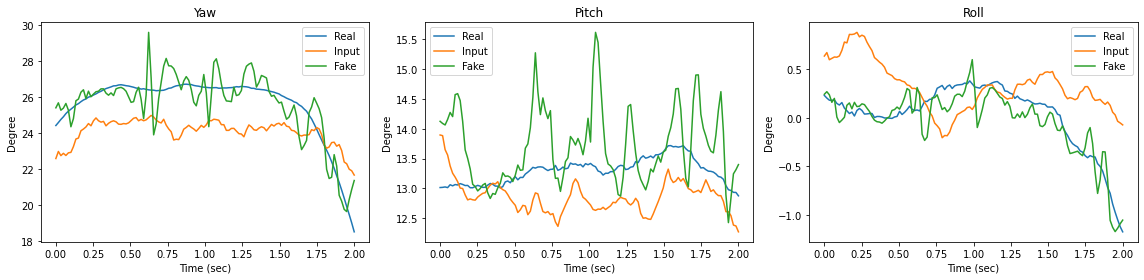

Train Epoch[181/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0004, d_loss_fake: 0.0002 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[181/1000] Step [01/01] d_loss: 1.6356, d_loss_real: 1.6263, d_loss_fake: 0.0093 g_loss: 0.0086 acc_real: 0.3778 acc_fake: 1.0000
Train Epoch[182/1000] Step [02/02] d_loss: 0.0007, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[182/1000] Step [01/01] d_loss: 1.5199, d_loss_real: 1.5084, d_loss_fake: 0.0116 g_loss: 0.0106 acc_real: 0.4444 acc_fake: 1.0000
Train Epoch[183/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[183/1000] Step [01/01] d_loss: 1.4001, d_loss_real: 1.3889, d_loss_fake: 0.0112 g_loss: 0.0102 acc_real: 0.5111 acc_fake: 1.0000
Train Epoch[184/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.000

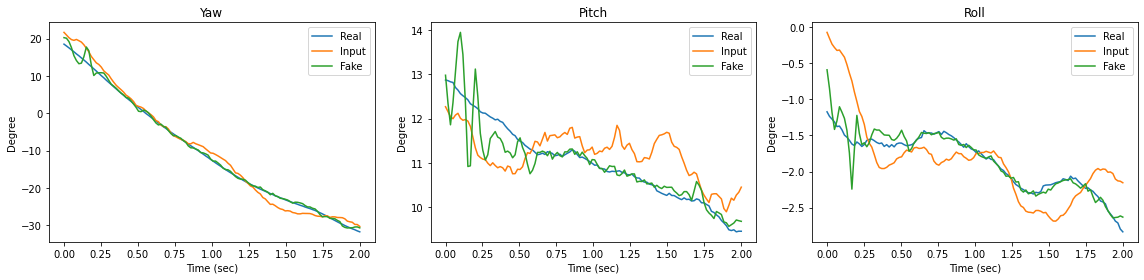

Train Epoch[191/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[191/1000] Step [01/01] d_loss: 1.6152, d_loss_real: 1.6052, d_loss_fake: 0.0101 g_loss: 0.0092 acc_real: 0.4000 acc_fake: 1.0000
Train Epoch[192/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[192/1000] Step [01/01] d_loss: 1.5072, d_loss_real: 1.4970, d_loss_fake: 0.0102 g_loss: 0.0093 acc_real: 0.4667 acc_fake: 1.0000
Train Epoch[193/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[193/1000] Step [01/01] d_loss: 1.5612, d_loss_real: 1.5520, d_loss_fake: 0.0091 g_loss: 0.0084 acc_real: 0.4222 acc_fake: 1.0000
Train Epoch[194/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.000

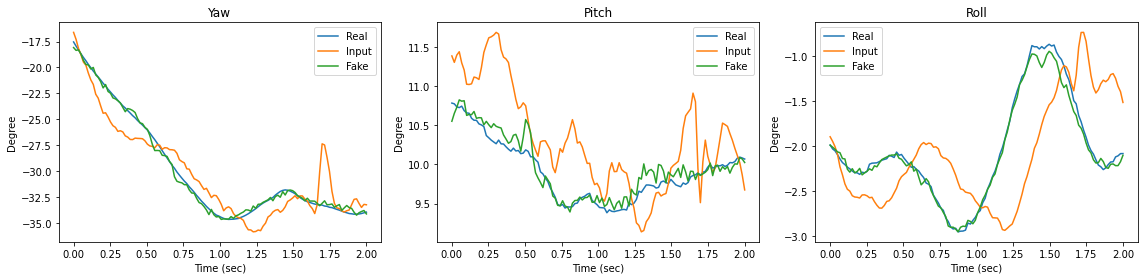

Train Epoch[201/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[201/1000] Step [01/01] d_loss: 1.6438, d_loss_real: 1.6340, d_loss_fake: 0.0099 g_loss: 0.0090 acc_real: 0.4000 acc_fake: 1.0000
Train Epoch[202/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0004, d_loss_fake: 0.0002 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[202/1000] Step [01/01] d_loss: 1.6312, d_loss_real: 1.6229, d_loss_fake: 0.0083 g_loss: 0.0076 acc_real: 0.4000 acc_fake: 1.0000
Train Epoch[203/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[203/1000] Step [01/01] d_loss: 1.6454, d_loss_real: 1.6363, d_loss_fake: 0.0091 g_loss: 0.0084 acc_real: 0.3778 acc_fake: 1.0000
Train Epoch[204/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.000

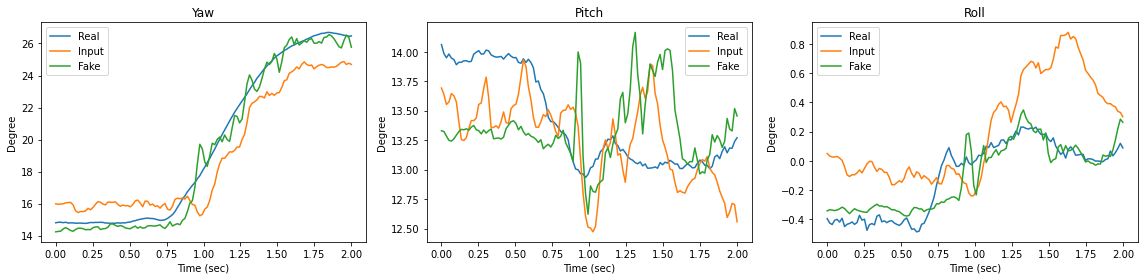

Train Epoch[211/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[211/1000] Step [01/01] d_loss: 2.0679, d_loss_real: 2.0617, d_loss_fake: 0.0062 g_loss: 0.0057 acc_real: 0.2889 acc_fake: 1.0000
Train Epoch[212/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[212/1000] Step [01/01] d_loss: 2.4999, d_loss_real: 2.4945, d_loss_fake: 0.0054 g_loss: 0.0050 acc_real: 0.1556 acc_fake: 1.0000
Train Epoch[213/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[213/1000] Step [01/01] d_loss: 2.4339, d_loss_real: 2.2632, d_loss_fake: 0.1708 g_loss: 0.1539 acc_real: 0.2000 acc_fake: 0.9333
Train Epoch[214/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.000

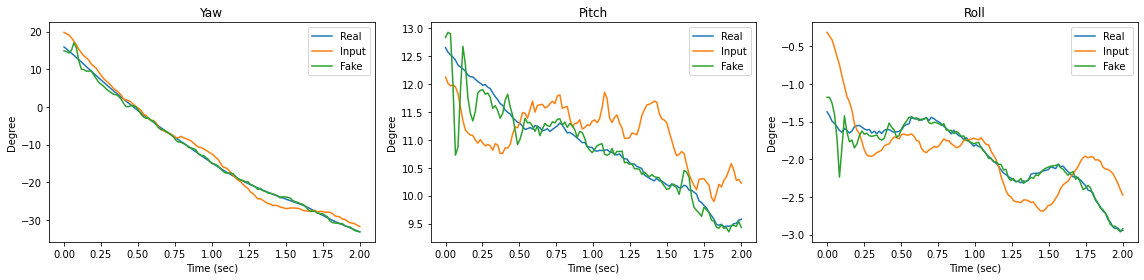

Train Epoch[221/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[221/1000] Step [01/01] d_loss: 1.7195, d_loss_real: 1.7115, d_loss_fake: 0.0080 g_loss: 0.0073 acc_real: 0.3778 acc_fake: 1.0000
Train Epoch[222/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[222/1000] Step [01/01] d_loss: 1.8407, d_loss_real: 1.8344, d_loss_fake: 0.0063 g_loss: 0.0058 acc_real: 0.3778 acc_fake: 1.0000
Train Epoch[223/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[223/1000] Step [01/01] d_loss: 1.9010, d_loss_real: 1.8714, d_loss_fake: 0.0296 g_loss: 0.0268 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[224/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.000

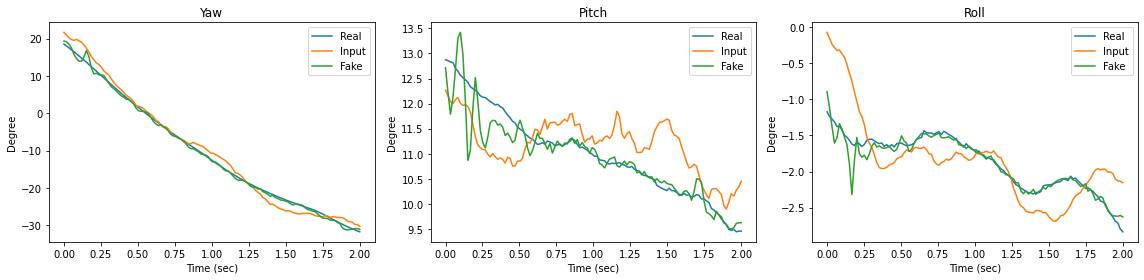

Train Epoch[231/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[231/1000] Step [01/01] d_loss: 1.8340, d_loss_real: 1.8262, d_loss_fake: 0.0079 g_loss: 0.0072 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[232/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[232/1000] Step [01/01] d_loss: 2.0041, d_loss_real: 1.9973, d_loss_fake: 0.0068 g_loss: 0.0062 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[233/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[233/1000] Step [01/01] d_loss: 1.8977, d_loss_real: 1.8909, d_loss_fake: 0.0068 g_loss: 0.0062 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[234/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.000

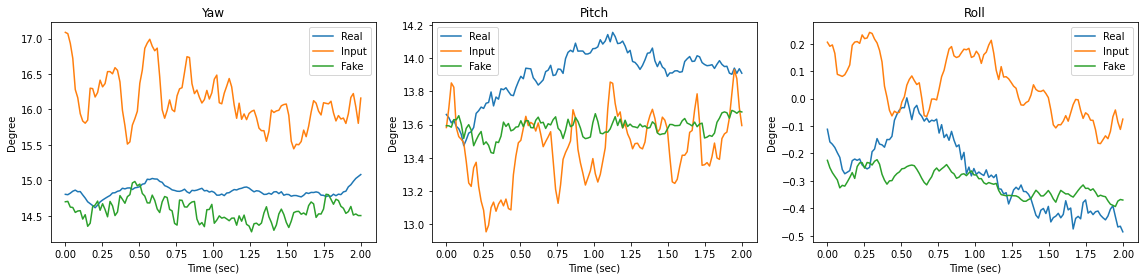

Train Epoch[241/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[241/1000] Step [01/01] d_loss: 1.8212, d_loss_real: 1.8127, d_loss_fake: 0.0085 g_loss: 0.0078 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[242/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[242/1000] Step [01/01] d_loss: 1.9131, d_loss_real: 1.9061, d_loss_fake: 0.0070 g_loss: 0.0064 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[243/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[243/1000] Step [01/01] d_loss: 2.0177, d_loss_real: 2.0110, d_loss_fake: 0.0067 g_loss: 0.0062 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[244/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

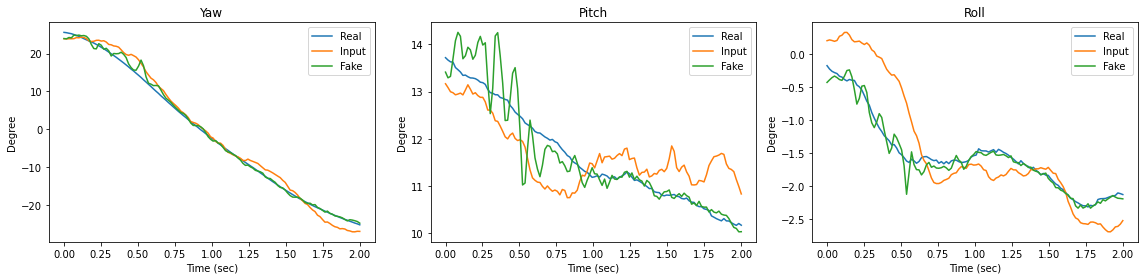

Train Epoch[251/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[251/1000] Step [01/01] d_loss: 1.9655, d_loss_real: 1.9471, d_loss_fake: 0.0183 g_loss: 0.0166 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[252/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[252/1000] Step [01/01] d_loss: 1.7068, d_loss_real: 1.6961, d_loss_fake: 0.0108 g_loss: 0.0098 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[253/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[253/1000] Step [01/01] d_loss: 1.8325, d_loss_real: 1.8246, d_loss_fake: 0.0079 g_loss: 0.0072 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[254/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

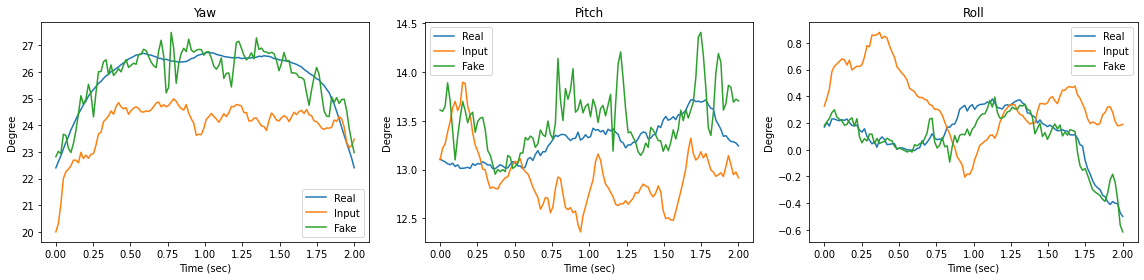

Train Epoch[261/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[261/1000] Step [01/01] d_loss: 2.0552, d_loss_real: 2.0486, d_loss_fake: 0.0066 g_loss: 0.0060 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[262/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[262/1000] Step [01/01] d_loss: 1.8956, d_loss_real: 1.8893, d_loss_fake: 0.0063 g_loss: 0.0058 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[263/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[263/1000] Step [01/01] d_loss: 2.5024, d_loss_real: 2.4980, d_loss_fake: 0.0044 g_loss: 0.0042 acc_real: 0.1556 acc_fake: 1.0000
Train Epoch[264/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.000

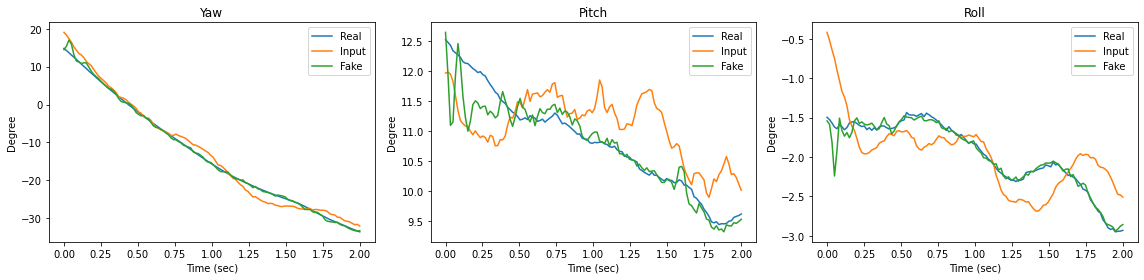

Train Epoch[271/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[271/1000] Step [01/01] d_loss: 2.2057, d_loss_real: 2.1994, d_loss_fake: 0.0063 g_loss: 0.0058 acc_real: 0.2444 acc_fake: 1.0000
Train Epoch[272/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[272/1000] Step [01/01] d_loss: 2.3512, d_loss_real: 2.3451, d_loss_fake: 0.0061 g_loss: 0.0056 acc_real: 0.1333 acc_fake: 1.0000
Train Epoch[273/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[273/1000] Step [01/01] d_loss: 2.0992, d_loss_real: 2.0931, d_loss_fake: 0.0061 g_loss: 0.0055 acc_real: 0.3111 acc_fake: 1.0000
Train Epoch[274/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

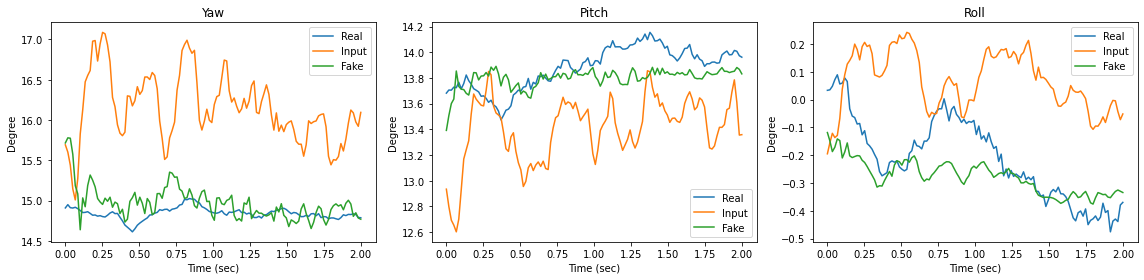

Train Epoch[281/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[281/1000] Step [01/01] d_loss: 2.1256, d_loss_real: 2.1169, d_loss_fake: 0.0087 g_loss: 0.0079 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[282/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[282/1000] Step [01/01] d_loss: 2.2508, d_loss_real: 2.2454, d_loss_fake: 0.0054 g_loss: 0.0049 acc_real: 0.2444 acc_fake: 1.0000
Train Epoch[283/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[283/1000] Step [01/01] d_loss: 2.5656, d_loss_real: 2.5610, d_loss_fake: 0.0046 g_loss: 0.0042 acc_real: 0.1333 acc_fake: 1.0000
Train Epoch[284/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

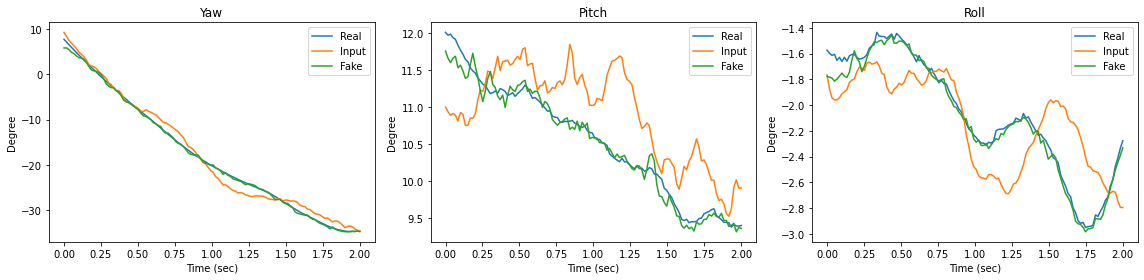

Train Epoch[291/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[291/1000] Step [01/01] d_loss: 2.1173, d_loss_real: 2.1098, d_loss_fake: 0.0075 g_loss: 0.0069 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[292/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[292/1000] Step [01/01] d_loss: 2.0022, d_loss_real: 1.9950, d_loss_fake: 0.0072 g_loss: 0.0066 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[293/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[293/1000] Step [01/01] d_loss: 2.0116, d_loss_real: 2.0050, d_loss_fake: 0.0067 g_loss: 0.0061 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[294/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

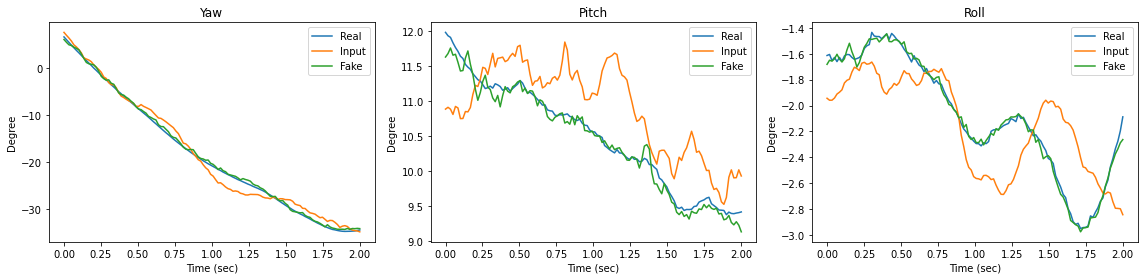

Train Epoch[301/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[301/1000] Step [01/01] d_loss: 2.0147, d_loss_real: 2.0080, d_loss_fake: 0.0066 g_loss: 0.0060 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[302/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[302/1000] Step [01/01] d_loss: 2.1559, d_loss_real: 2.1453, d_loss_fake: 0.0106 g_loss: 0.0096 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[303/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[303/1000] Step [01/01] d_loss: 2.0812, d_loss_real: 2.0712, d_loss_fake: 0.0100 g_loss: 0.0091 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[304/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

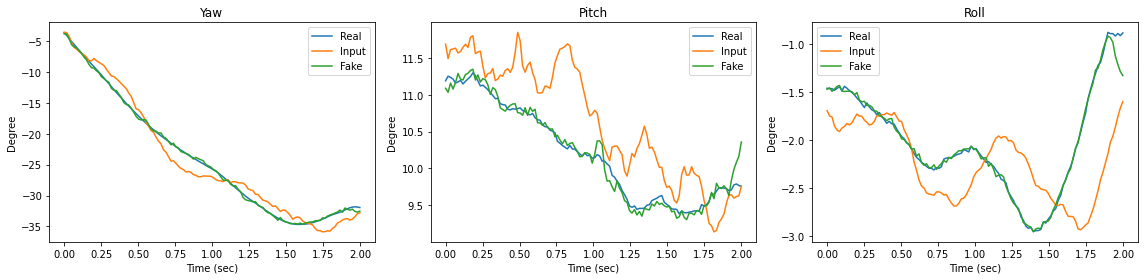

Train Epoch[311/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[311/1000] Step [01/01] d_loss: 2.1408, d_loss_real: 2.1346, d_loss_fake: 0.0062 g_loss: 0.0056 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[312/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[312/1000] Step [01/01] d_loss: 2.0004, d_loss_real: 1.9941, d_loss_fake: 0.0063 g_loss: 0.0057 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[313/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[313/1000] Step [01/01] d_loss: 2.0351, d_loss_real: 2.0289, d_loss_fake: 0.0062 g_loss: 0.0057 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[314/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

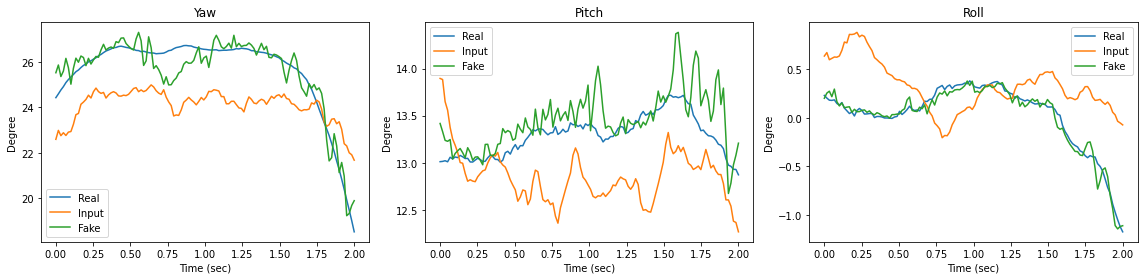

Train Epoch[321/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[321/1000] Step [01/01] d_loss: 2.1040, d_loss_real: 2.0975, d_loss_fake: 0.0064 g_loss: 0.0059 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[322/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[322/1000] Step [01/01] d_loss: 2.1384, d_loss_real: 2.1318, d_loss_fake: 0.0066 g_loss: 0.0060 acc_real: 0.3111 acc_fake: 1.0000
Train Epoch[323/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[323/1000] Step [01/01] d_loss: 2.3285, d_loss_real: 2.3227, d_loss_fake: 0.0058 g_loss: 0.0053 acc_real: 0.2667 acc_fake: 1.0000
Train Epoch[324/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

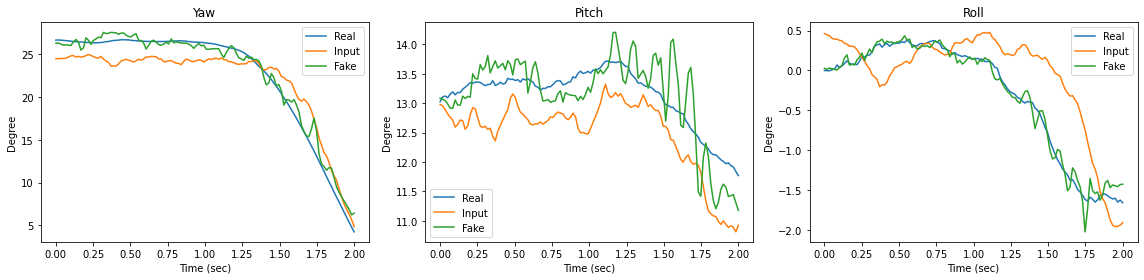

Train Epoch[331/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[331/1000] Step [01/01] d_loss: 2.4250, d_loss_real: 2.4198, d_loss_fake: 0.0052 g_loss: 0.0047 acc_real: 0.2222 acc_fake: 1.0000
Train Epoch[332/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[332/1000] Step [01/01] d_loss: 2.5317, d_loss_real: 2.5267, d_loss_fake: 0.0050 g_loss: 0.0046 acc_real: 0.1556 acc_fake: 1.0000
Train Epoch[333/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[333/1000] Step [01/01] d_loss: 2.4432, d_loss_real: 2.4332, d_loss_fake: 0.0099 g_loss: 0.0090 acc_real: 0.2222 acc_fake: 1.0000
Train Epoch[334/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

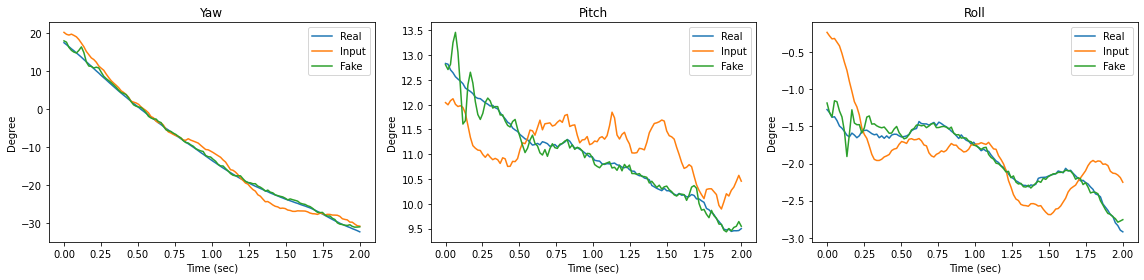

Train Epoch[341/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[341/1000] Step [01/01] d_loss: 2.2356, d_loss_real: 2.2301, d_loss_fake: 0.0055 g_loss: 0.0050 acc_real: 0.2889 acc_fake: 1.0000
Train Epoch[342/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[342/1000] Step [01/01] d_loss: 2.1998, d_loss_real: 2.1939, d_loss_fake: 0.0059 g_loss: 0.0053 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[343/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[343/1000] Step [01/01] d_loss: 2.1251, d_loss_real: 2.1185, d_loss_fake: 0.0066 g_loss: 0.0060 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[344/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.000

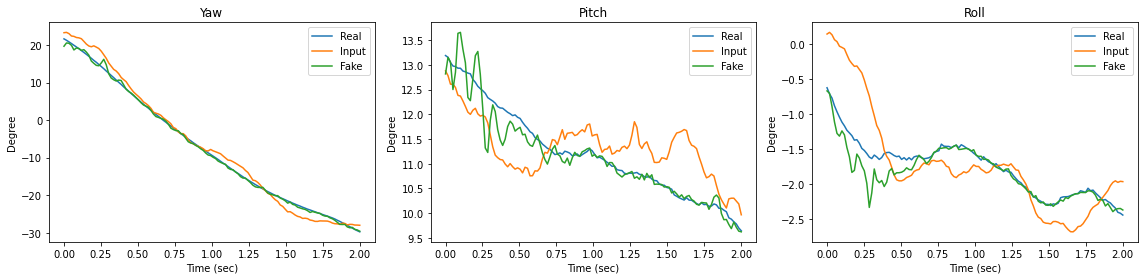

Train Epoch[351/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[351/1000] Step [01/01] d_loss: 2.1673, d_loss_real: 2.1609, d_loss_fake: 0.0064 g_loss: 0.0058 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[352/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[352/1000] Step [01/01] d_loss: 1.9729, d_loss_real: 1.9656, d_loss_fake: 0.0073 g_loss: 0.0067 acc_real: 0.3778 acc_fake: 1.0000
Train Epoch[353/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[353/1000] Step [01/01] d_loss: 1.9202, d_loss_real: 1.9131, d_loss_fake: 0.0071 g_loss: 0.0064 acc_real: 0.3778 acc_fake: 1.0000
Train Epoch[354/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.000

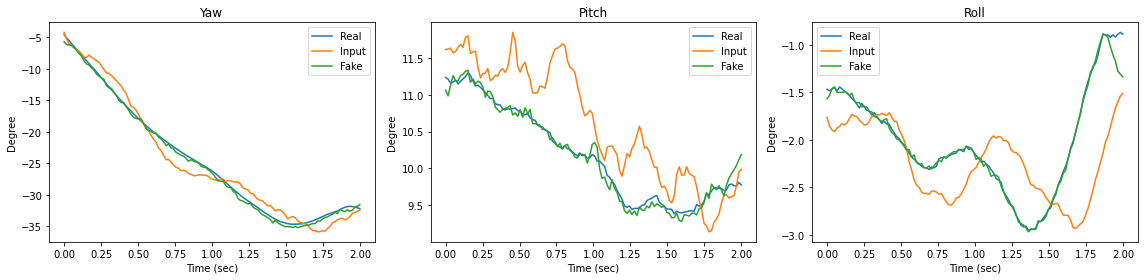

Train Epoch[361/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[361/1000] Step [01/01] d_loss: 2.1613, d_loss_real: 2.1526, d_loss_fake: 0.0087 g_loss: 0.0079 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[362/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[362/1000] Step [01/01] d_loss: 2.0816, d_loss_real: 2.0744, d_loss_fake: 0.0071 g_loss: 0.0065 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[363/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[363/1000] Step [01/01] d_loss: 2.0764, d_loss_real: 2.0704, d_loss_fake: 0.0060 g_loss: 0.0055 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[364/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

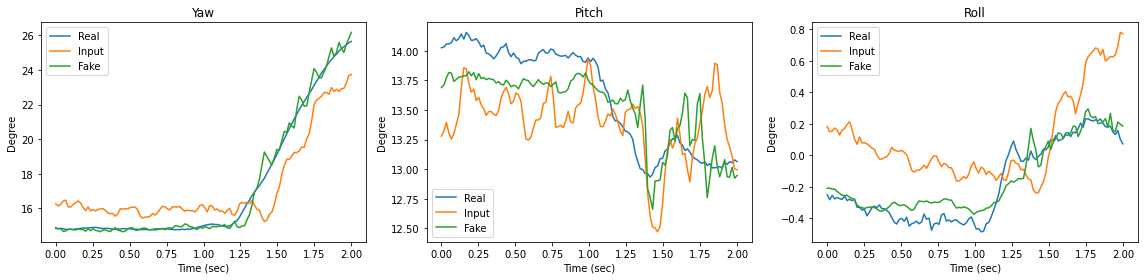

Train Epoch[371/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[371/1000] Step [01/01] d_loss: 2.1976, d_loss_real: 2.1783, d_loss_fake: 0.0193 g_loss: 0.0174 acc_real: 0.3556 acc_fake: 1.0000
Train Epoch[372/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[372/1000] Step [01/01] d_loss: 2.2155, d_loss_real: 2.2077, d_loss_fake: 0.0077 g_loss: 0.0070 acc_real: 0.2889 acc_fake: 1.0000
Train Epoch[373/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[373/1000] Step [01/01] d_loss: 2.3278, d_loss_real: 2.3220, d_loss_fake: 0.0058 g_loss: 0.0053 acc_real: 0.2444 acc_fake: 1.0000
Train Epoch[374/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

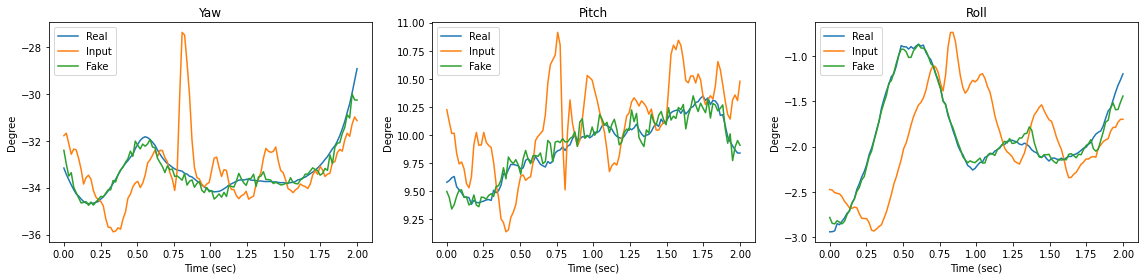

Train Epoch[381/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[381/1000] Step [01/01] d_loss: 2.1379, d_loss_real: 2.1322, d_loss_fake: 0.0058 g_loss: 0.0052 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[382/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[382/1000] Step [01/01] d_loss: 2.4329, d_loss_real: 2.4283, d_loss_fake: 0.0046 g_loss: 0.0042 acc_real: 0.2444 acc_fake: 1.0000
Train Epoch[383/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[383/1000] Step [01/01] d_loss: 2.4423, d_loss_real: 2.4066, d_loss_fake: 0.0357 g_loss: 0.0322 acc_real: 0.2667 acc_fake: 1.0000
Train Epoch[384/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

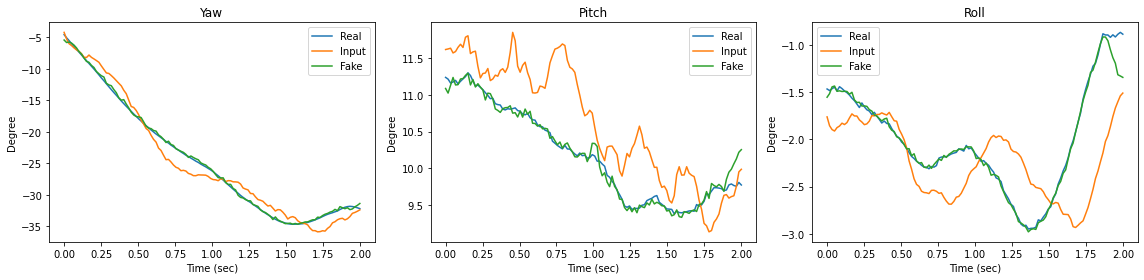

Train Epoch[391/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[391/1000] Step [01/01] d_loss: 2.2467, d_loss_real: 2.2417, d_loss_fake: 0.0050 g_loss: 0.0045 acc_real: 0.3111 acc_fake: 1.0000
Train Epoch[392/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[392/1000] Step [01/01] d_loss: 2.2430, d_loss_real: 2.2369, d_loss_fake: 0.0060 g_loss: 0.0055 acc_real: 0.3111 acc_fake: 1.0000
Train Epoch[393/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[393/1000] Step [01/01] d_loss: 2.1796, d_loss_real: 2.1730, d_loss_fake: 0.0066 g_loss: 0.0060 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[394/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

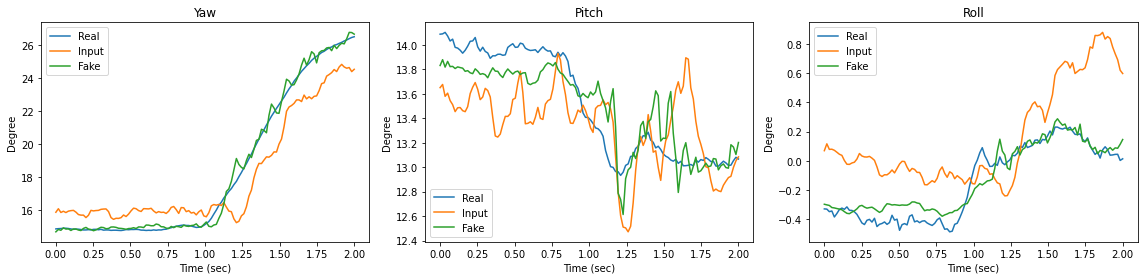

Train Epoch[401/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[401/1000] Step [01/01] d_loss: 2.2520, d_loss_real: 2.2461, d_loss_fake: 0.0058 g_loss: 0.0053 acc_real: 0.3333 acc_fake: 1.0000
Train Epoch[402/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[402/1000] Step [01/01] d_loss: 2.1144, d_loss_real: 2.1078, d_loss_fake: 0.0066 g_loss: 0.0060 acc_real: 0.4000 acc_fake: 1.0000
Train Epoch[403/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[403/1000] Step [01/01] d_loss: 2.2578, d_loss_real: 2.2525, d_loss_fake: 0.0053 g_loss: 0.0048 acc_real: 0.3111 acc_fake: 1.0000
Train Epoch[404/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

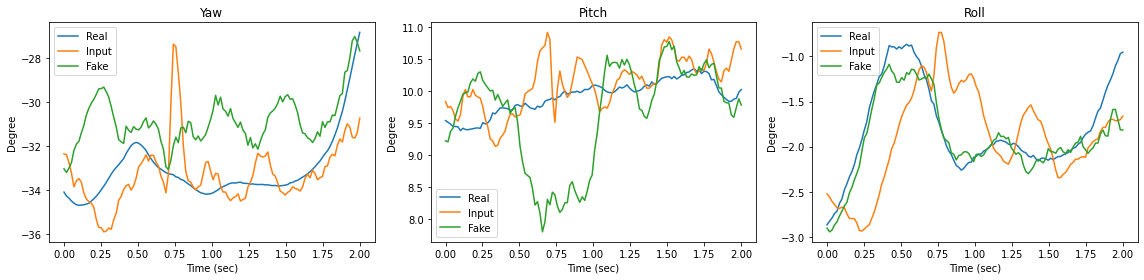

Train Epoch[411/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0001, d_loss_fake: 0.0002 g_loss: 0.0011 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[411/1000] Step [01/01] d_loss: 1.9582, d_loss_real: 1.9056, d_loss_fake: 0.0526 g_loss: 0.0485 acc_real: 0.1556 acc_fake: 1.0000
Train Epoch[412/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0001, d_loss_fake: 0.0002 g_loss: 0.0009 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[412/1000] Step [01/01] d_loss: 2.2654, d_loss_real: 2.2418, d_loss_fake: 0.0236 g_loss: 0.0221 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[413/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[413/1000] Step [01/01] d_loss: 2.7689, d_loss_real: 2.7622, d_loss_fake: 0.0067 g_loss: 0.0067 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[414/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006 acc_real: 1.0000 acc_fake: 1.000

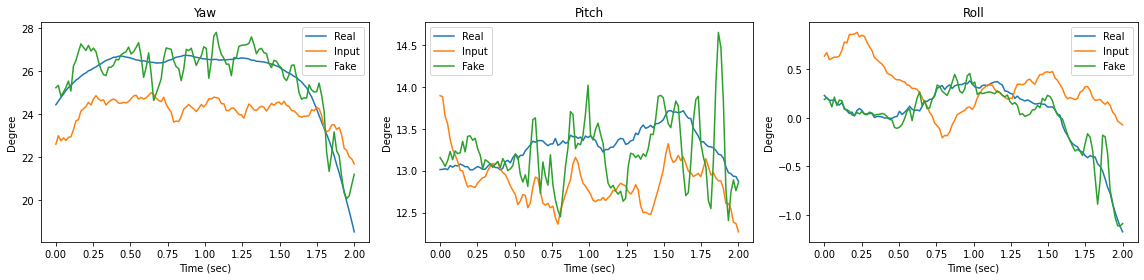

Train Epoch[421/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[421/1000] Step [01/01] d_loss: 3.2263, d_loss_real: 3.2186, d_loss_fake: 0.0078 g_loss: 0.0072 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[422/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[422/1000] Step [01/01] d_loss: 3.2296, d_loss_real: 3.2243, d_loss_fake: 0.0053 g_loss: 0.0049 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[423/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[423/1000] Step [01/01] d_loss: 3.1968, d_loss_real: 3.1914, d_loss_fake: 0.0054 g_loss: 0.0051 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[424/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

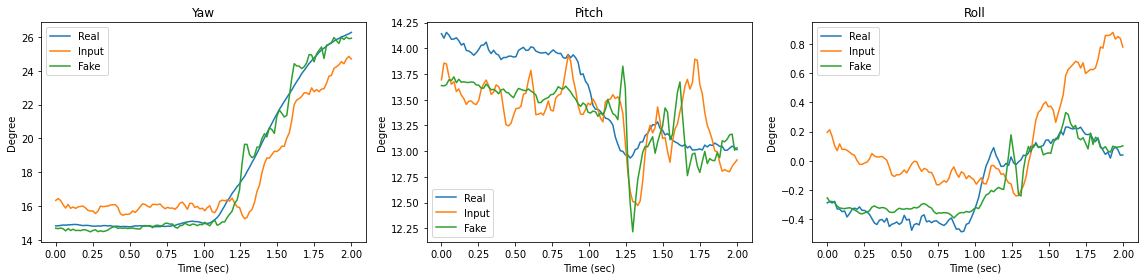

Train Epoch[431/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[431/1000] Step [01/01] d_loss: 3.3895, d_loss_real: 3.3860, d_loss_fake: 0.0035 g_loss: 0.0033 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[432/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[432/1000] Step [01/01] d_loss: 3.4898, d_loss_real: 3.4861, d_loss_fake: 0.0037 g_loss: 0.0035 acc_real: 0.0222 acc_fake: 1.0000
Train Epoch[433/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[433/1000] Step [01/01] d_loss: 3.4390, d_loss_real: 3.4003, d_loss_fake: 0.0387 g_loss: 0.0350 acc_real: 0.0667 acc_fake: 0.9778
Train Epoch[434/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

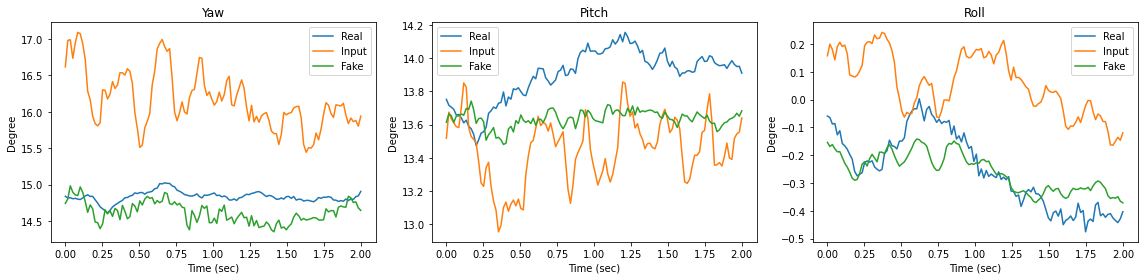

Train Epoch[441/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[441/1000] Step [01/01] d_loss: 3.1984, d_loss_real: 3.1667, d_loss_fake: 0.0316 g_loss: 0.0285 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[442/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[442/1000] Step [01/01] d_loss: 3.0475, d_loss_real: 3.0432, d_loss_fake: 0.0043 g_loss: 0.0040 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[443/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[443/1000] Step [01/01] d_loss: 3.2941, d_loss_real: 3.2901, d_loss_fake: 0.0040 g_loss: 0.0037 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[444/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

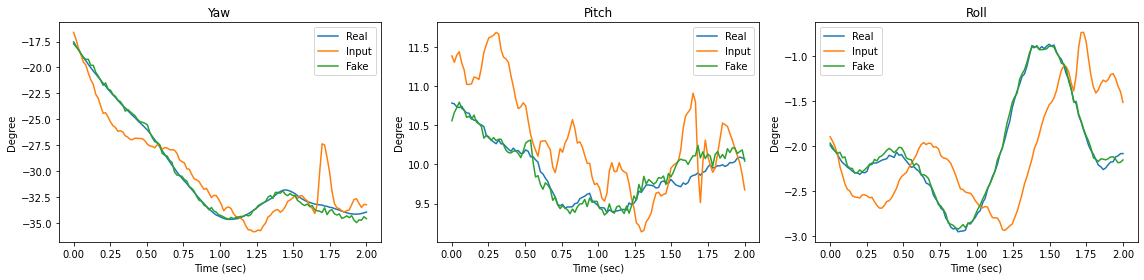

Train Epoch[451/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[451/1000] Step [01/01] d_loss: 3.2489, d_loss_real: 3.2212, d_loss_fake: 0.0277 g_loss: 0.0250 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[452/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[452/1000] Step [01/01] d_loss: 3.2015, d_loss_real: 3.1968, d_loss_fake: 0.0047 g_loss: 0.0043 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[453/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[453/1000] Step [01/01] d_loss: 3.0702, d_loss_real: 3.0659, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[454/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

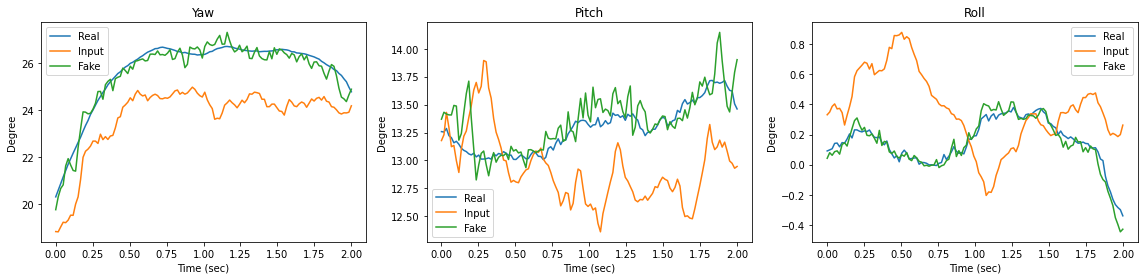

Train Epoch[461/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[461/1000] Step [01/01] d_loss: 3.0332, d_loss_real: 3.0290, d_loss_fake: 0.0042 g_loss: 0.0039 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[462/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[462/1000] Step [01/01] d_loss: 3.1127, d_loss_real: 3.1087, d_loss_fake: 0.0041 g_loss: 0.0037 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[463/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[463/1000] Step [01/01] d_loss: 3.1250, d_loss_real: 3.1158, d_loss_fake: 0.0092 g_loss: 0.0083 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[464/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

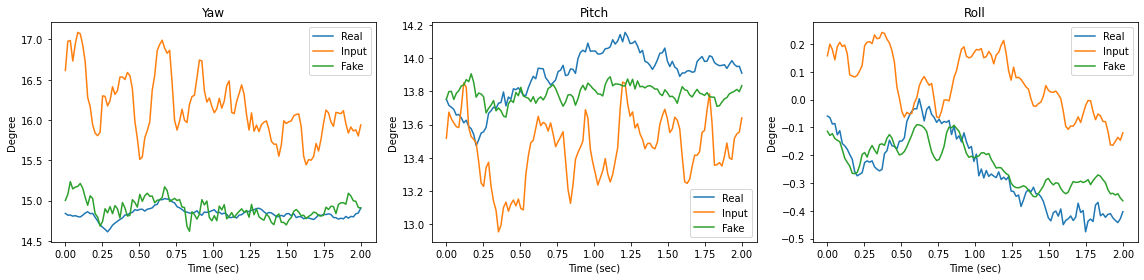

Train Epoch[471/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[471/1000] Step [01/01] d_loss: 2.9898, d_loss_real: 2.9806, d_loss_fake: 0.0092 g_loss: 0.0083 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[472/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[472/1000] Step [01/01] d_loss: 3.0905, d_loss_real: 3.0859, d_loss_fake: 0.0046 g_loss: 0.0042 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[473/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[473/1000] Step [01/01] d_loss: 3.1040, d_loss_real: 3.0998, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[474/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

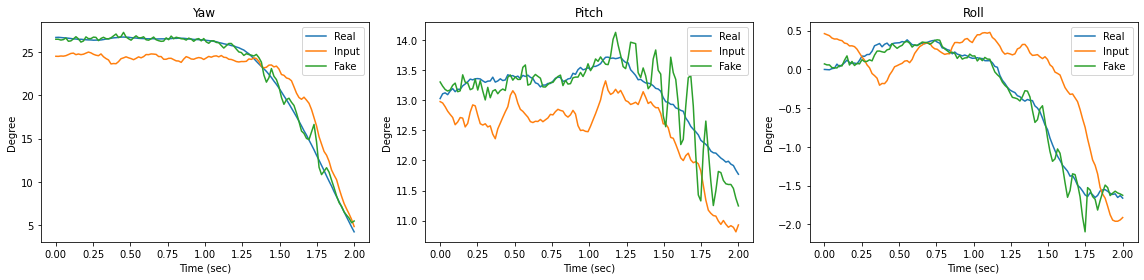

Train Epoch[481/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[481/1000] Step [01/01] d_loss: 3.2045, d_loss_real: 3.2006, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[482/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[482/1000] Step [01/01] d_loss: 3.2639, d_loss_real: 3.2603, d_loss_fake: 0.0036 g_loss: 0.0032 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[483/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[483/1000] Step [01/01] d_loss: 3.2769, d_loss_real: 3.2714, d_loss_fake: 0.0055 g_loss: 0.0050 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[484/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

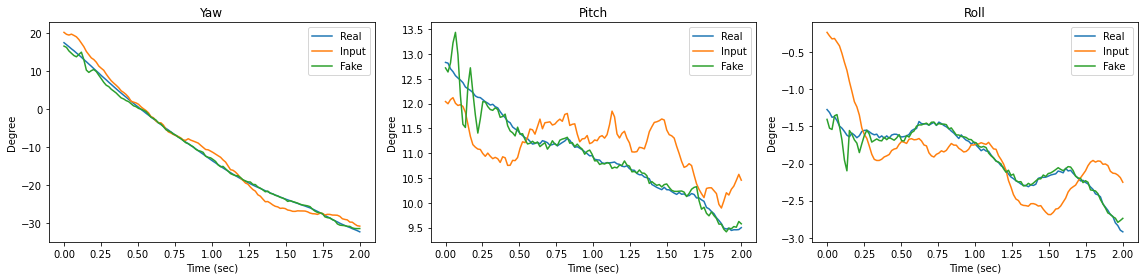

Train Epoch[491/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[491/1000] Step [01/01] d_loss: 3.0620, d_loss_real: 3.0552, d_loss_fake: 0.0069 g_loss: 0.0062 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[492/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[492/1000] Step [01/01] d_loss: 3.0010, d_loss_real: 2.9931, d_loss_fake: 0.0079 g_loss: 0.0071 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[493/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[493/1000] Step [01/01] d_loss: 2.9155, d_loss_real: 2.9108, d_loss_fake: 0.0048 g_loss: 0.0043 acc_real: 0.1333 acc_fake: 1.0000
Train Epoch[494/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

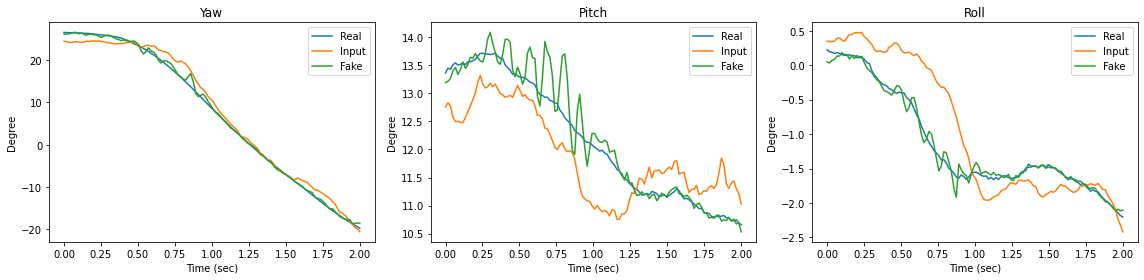

Train Epoch[501/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[501/1000] Step [01/01] d_loss: 3.2675, d_loss_real: 3.2622, d_loss_fake: 0.0053 g_loss: 0.0049 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[502/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[502/1000] Step [01/01] d_loss: 3.0126, d_loss_real: 3.0072, d_loss_fake: 0.0054 g_loss: 0.0049 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[503/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[503/1000] Step [01/01] d_loss: 3.1913, d_loss_real: 3.1877, d_loss_fake: 0.0036 g_loss: 0.0033 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[504/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

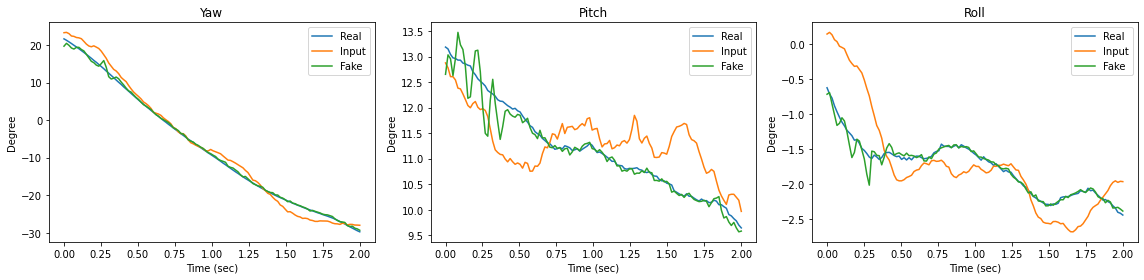

Train Epoch[511/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[511/1000] Step [01/01] d_loss: 3.0413, d_loss_real: 3.0371, d_loss_fake: 0.0042 g_loss: 0.0038 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[512/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[512/1000] Step [01/01] d_loss: 3.0847, d_loss_real: 3.0803, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[513/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[513/1000] Step [01/01] d_loss: 3.2370, d_loss_real: 3.2314, d_loss_fake: 0.0056 g_loss: 0.0051 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[514/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

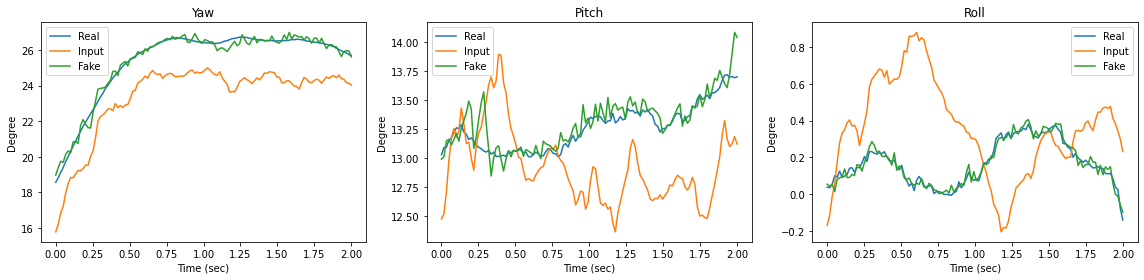

Train Epoch[521/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[521/1000] Step [01/01] d_loss: 3.1541, d_loss_real: 3.1460, d_loss_fake: 0.0080 g_loss: 0.0072 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[522/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[522/1000] Step [01/01] d_loss: 3.0431, d_loss_real: 3.0384, d_loss_fake: 0.0047 g_loss: 0.0043 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[523/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[523/1000] Step [01/01] d_loss: 3.1051, d_loss_real: 3.1010, d_loss_fake: 0.0041 g_loss: 0.0037 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[524/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

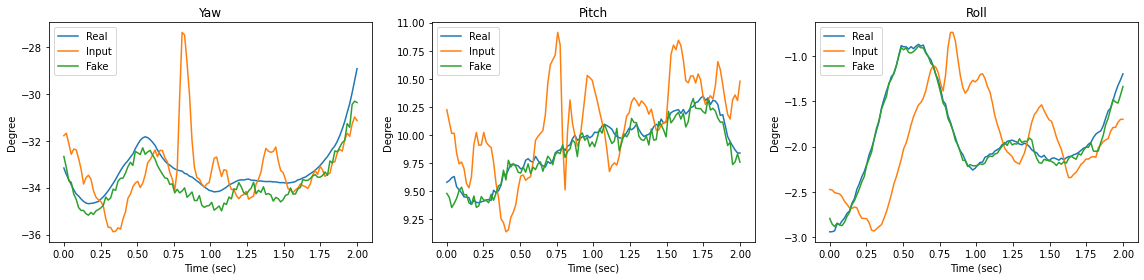

Train Epoch[531/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[531/1000] Step [01/01] d_loss: 3.3349, d_loss_real: 3.3314, d_loss_fake: 0.0035 g_loss: 0.0032 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[532/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[532/1000] Step [01/01] d_loss: 3.3559, d_loss_real: 3.3520, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[533/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[533/1000] Step [01/01] d_loss: 3.2591, d_loss_real: 3.2546, d_loss_fake: 0.0045 g_loss: 0.0041 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[534/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

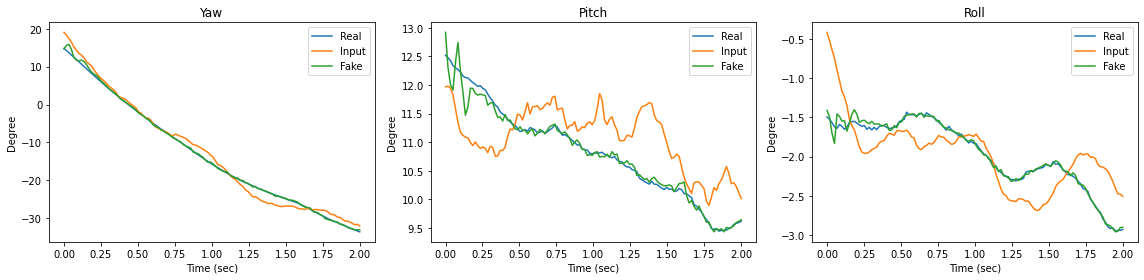

Train Epoch[541/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[541/1000] Step [01/01] d_loss: 3.1146, d_loss_real: 3.1105, d_loss_fake: 0.0042 g_loss: 0.0038 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[542/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[542/1000] Step [01/01] d_loss: 3.1447, d_loss_real: 3.1404, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[543/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[543/1000] Step [01/01] d_loss: 3.1740, d_loss_real: 3.1679, d_loss_fake: 0.0061 g_loss: 0.0055 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[544/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

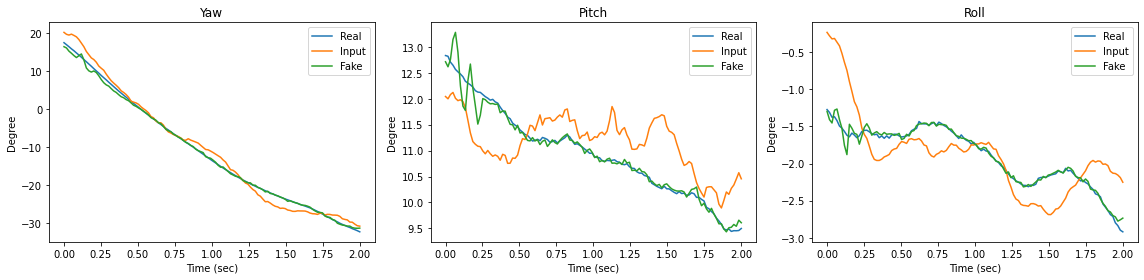

Train Epoch[551/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[551/1000] Step [01/01] d_loss: 2.9153, d_loss_real: 2.9103, d_loss_fake: 0.0051 g_loss: 0.0046 acc_real: 0.1333 acc_fake: 1.0000
Train Epoch[552/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[552/1000] Step [01/01] d_loss: 3.1076, d_loss_real: 3.1033, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[553/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[553/1000] Step [01/01] d_loss: 2.9767, d_loss_real: 2.9723, d_loss_fake: 0.0044 g_loss: 0.0040 acc_real: 0.1333 acc_fake: 1.0000
Train Epoch[554/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

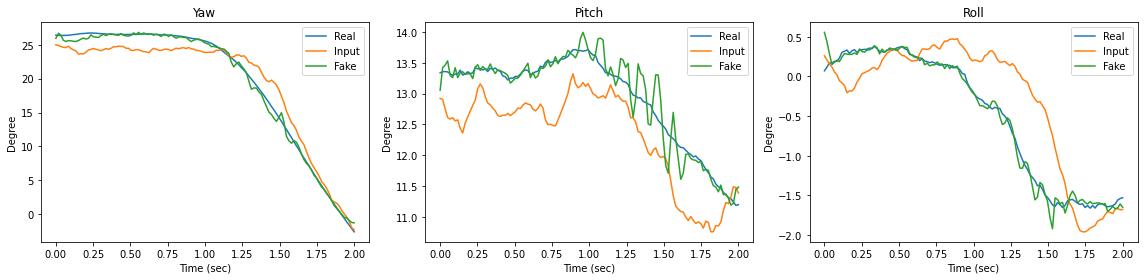

Train Epoch[561/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[561/1000] Step [01/01] d_loss: 3.1690, d_loss_real: 3.1650, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[562/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[562/1000] Step [01/01] d_loss: 3.0228, d_loss_real: 3.0184, d_loss_fake: 0.0044 g_loss: 0.0040 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[563/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[563/1000] Step [01/01] d_loss: 2.9960, d_loss_real: 2.9918, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[564/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

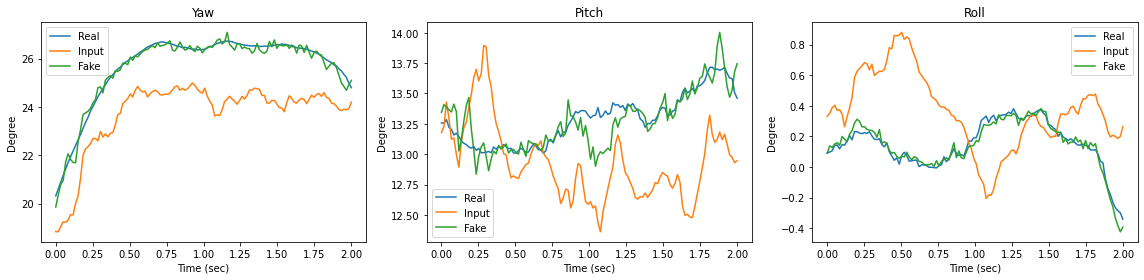

Train Epoch[571/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[571/1000] Step [01/01] d_loss: 3.0171, d_loss_real: 3.0129, d_loss_fake: 0.0042 g_loss: 0.0038 acc_real: 0.1333 acc_fake: 1.0000
Train Epoch[572/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[572/1000] Step [01/01] d_loss: 2.9481, d_loss_real: 2.9426, d_loss_fake: 0.0055 g_loss: 0.0050 acc_real: 0.1333 acc_fake: 1.0000
Train Epoch[573/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[573/1000] Step [01/01] d_loss: 3.0781, d_loss_real: 3.0741, d_loss_fake: 0.0040 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[574/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

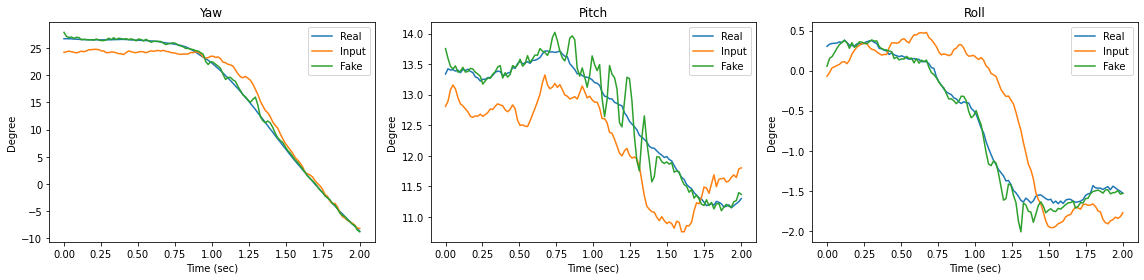

Train Epoch[581/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[581/1000] Step [01/01] d_loss: 3.2579, d_loss_real: 3.2539, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[582/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[582/1000] Step [01/01] d_loss: 3.0345, d_loss_real: 3.0307, d_loss_fake: 0.0038 g_loss: 0.0035 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[583/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[583/1000] Step [01/01] d_loss: 3.1638, d_loss_real: 3.1599, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[584/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

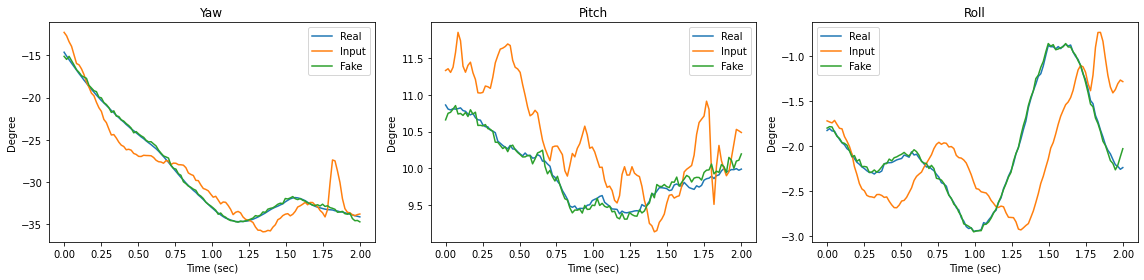

Train Epoch[591/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[591/1000] Step [01/01] d_loss: 3.0995, d_loss_real: 3.0952, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[592/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[592/1000] Step [01/01] d_loss: 3.1104, d_loss_real: 3.1030, d_loss_fake: 0.0074 g_loss: 0.0067 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[593/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[593/1000] Step [01/01] d_loss: 3.0479, d_loss_real: 3.0435, d_loss_fake: 0.0044 g_loss: 0.0039 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[594/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

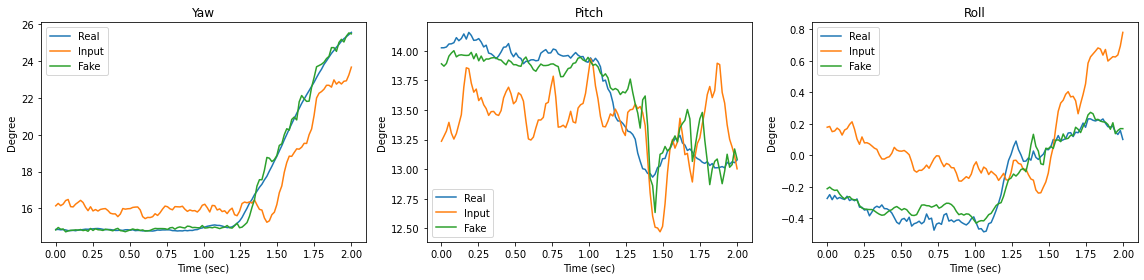

Train Epoch[601/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[601/1000] Step [01/01] d_loss: 3.0415, d_loss_real: 3.0375, d_loss_fake: 0.0040 g_loss: 0.0037 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[602/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[602/1000] Step [01/01] d_loss: 3.1982, d_loss_real: 3.1941, d_loss_fake: 0.0041 g_loss: 0.0037 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[603/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[603/1000] Step [01/01] d_loss: 3.0262, d_loss_real: 3.0221, d_loss_fake: 0.0041 g_loss: 0.0038 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[604/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

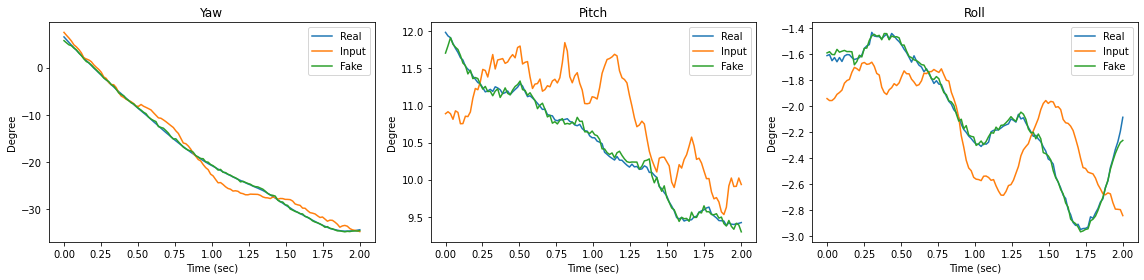

Train Epoch[611/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[611/1000] Step [01/01] d_loss: 3.0652, d_loss_real: 3.0613, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[612/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[612/1000] Step [01/01] d_loss: 2.8642, d_loss_real: 2.8594, d_loss_fake: 0.0048 g_loss: 0.0044 acc_real: 0.1333 acc_fake: 1.0000
Train Epoch[613/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[613/1000] Step [01/01] d_loss: 3.1299, d_loss_real: 3.1260, d_loss_fake: 0.0038 g_loss: 0.0035 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[614/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

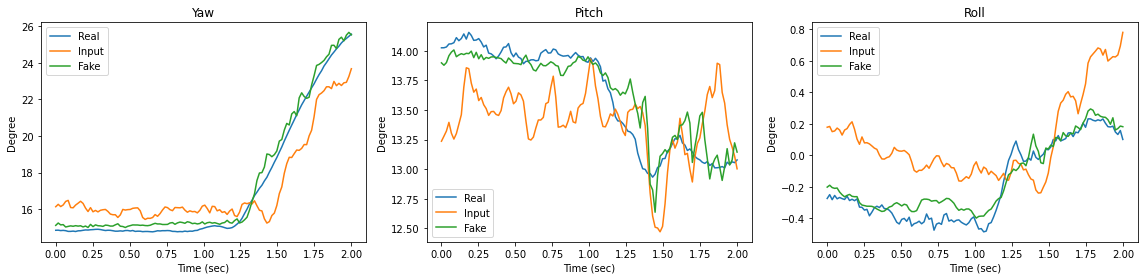

Train Epoch[621/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[621/1000] Step [01/01] d_loss: 3.2116, d_loss_real: 3.2079, d_loss_fake: 0.0037 g_loss: 0.0034 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[622/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[622/1000] Step [01/01] d_loss: 3.1292, d_loss_real: 3.1253, d_loss_fake: 0.0040 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[623/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[623/1000] Step [01/01] d_loss: 3.0537, d_loss_real: 3.0498, d_loss_fake: 0.0040 g_loss: 0.0036 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[624/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

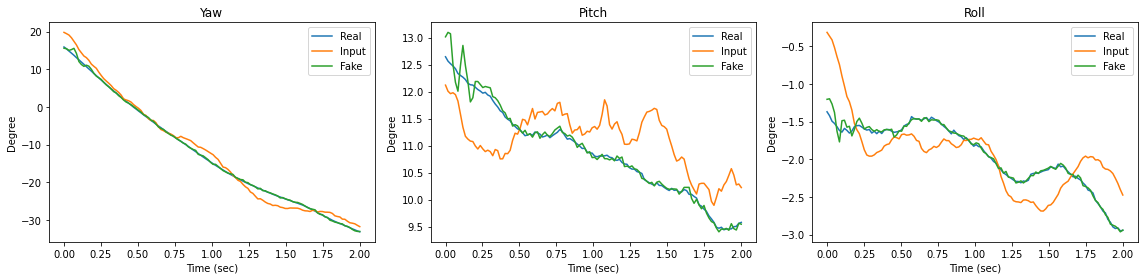

Train Epoch[631/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[631/1000] Step [01/01] d_loss: 2.9765, d_loss_real: 2.9726, d_loss_fake: 0.0039 g_loss: 0.0035 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[632/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[632/1000] Step [01/01] d_loss: 2.9744, d_loss_real: 2.9683, d_loss_fake: 0.0061 g_loss: 0.0056 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[633/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[633/1000] Step [01/01] d_loss: 2.9519, d_loss_real: 2.9461, d_loss_fake: 0.0058 g_loss: 0.0053 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[634/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

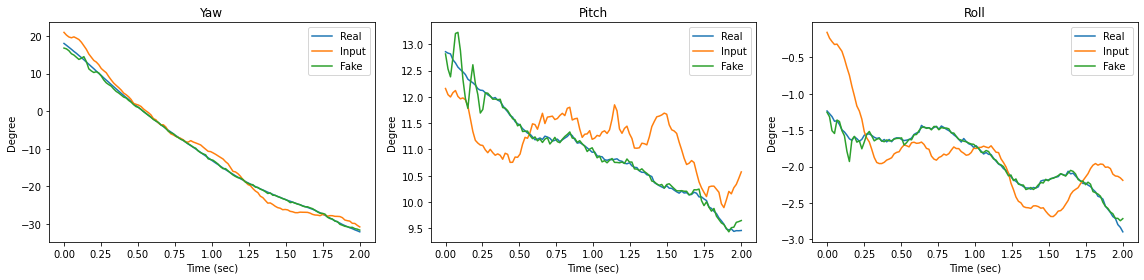

Train Epoch[641/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[641/1000] Step [01/01] d_loss: 2.9261, d_loss_real: 2.9217, d_loss_fake: 0.0045 g_loss: 0.0041 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[642/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[642/1000] Step [01/01] d_loss: 3.0253, d_loss_real: 3.0210, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[643/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[643/1000] Step [01/01] d_loss: 3.1225, d_loss_real: 3.1187, d_loss_fake: 0.0038 g_loss: 0.0034 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[644/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

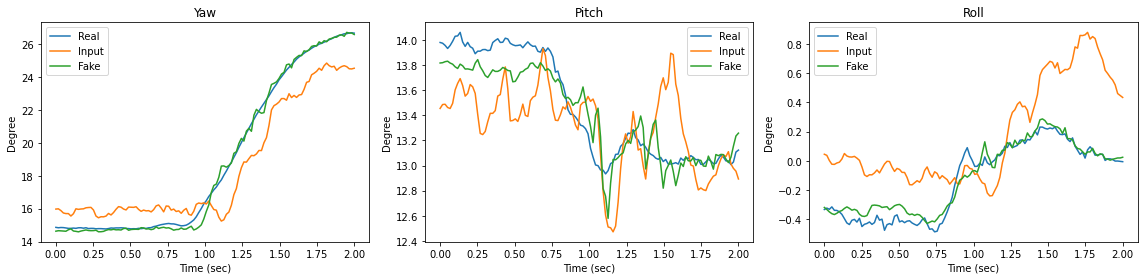

Train Epoch[651/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[651/1000] Step [01/01] d_loss: 3.0937, d_loss_real: 3.0896, d_loss_fake: 0.0041 g_loss: 0.0037 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[652/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[652/1000] Step [01/01] d_loss: 3.0714, d_loss_real: 3.0661, d_loss_fake: 0.0053 g_loss: 0.0048 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[653/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[653/1000] Step [01/01] d_loss: 3.3082, d_loss_real: 3.3043, d_loss_fake: 0.0039 g_loss: 0.0035 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[654/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

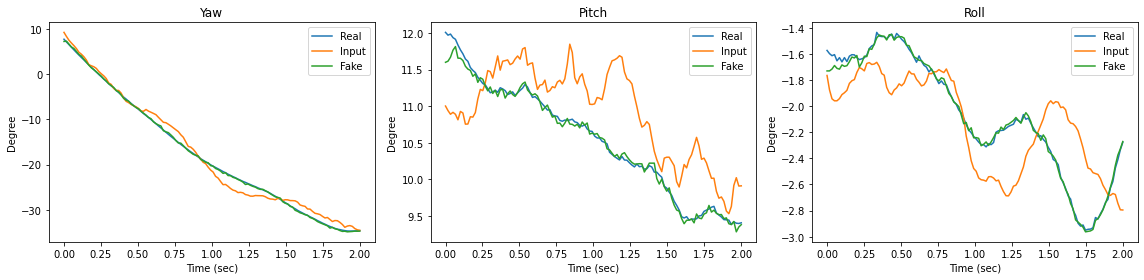

Train Epoch[661/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[661/1000] Step [01/01] d_loss: 3.3344, d_loss_real: 3.3309, d_loss_fake: 0.0034 g_loss: 0.0031 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[662/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[662/1000] Step [01/01] d_loss: 3.3687, d_loss_real: 3.3609, d_loss_fake: 0.0078 g_loss: 0.0070 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[663/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[663/1000] Step [01/01] d_loss: 3.2634, d_loss_real: 3.2596, d_loss_fake: 0.0038 g_loss: 0.0035 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[664/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

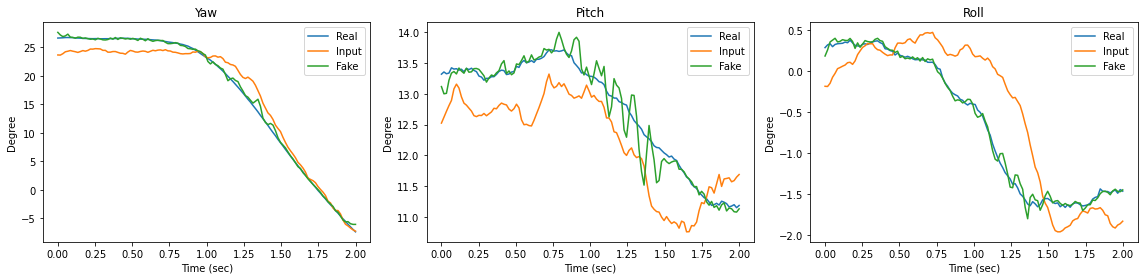

Train Epoch[671/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[671/1000] Step [01/01] d_loss: 3.3565, d_loss_real: 3.3467, d_loss_fake: 0.0097 g_loss: 0.0088 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[672/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[672/1000] Step [01/01] d_loss: 3.1831, d_loss_real: 3.1738, d_loss_fake: 0.0093 g_loss: 0.0084 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[673/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[673/1000] Step [01/01] d_loss: 3.2804, d_loss_real: 3.2763, d_loss_fake: 0.0041 g_loss: 0.0037 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[674/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

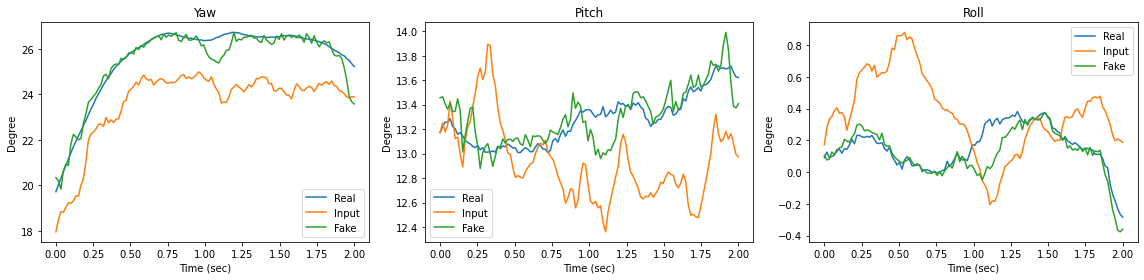

Train Epoch[681/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[681/1000] Step [01/01] d_loss: 3.2731, d_loss_real: 3.2696, d_loss_fake: 0.0036 g_loss: 0.0032 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[682/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[682/1000] Step [01/01] d_loss: 3.0743, d_loss_real: 3.0704, d_loss_fake: 0.0040 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[683/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[683/1000] Step [01/01] d_loss: 3.1160, d_loss_real: 3.1114, d_loss_fake: 0.0045 g_loss: 0.0041 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[684/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

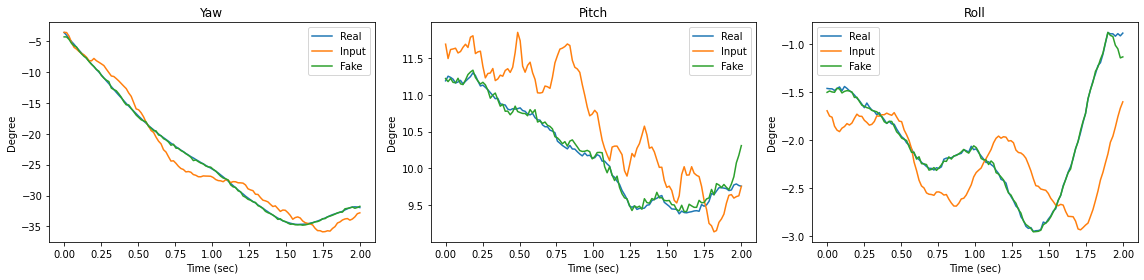

Train Epoch[691/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[691/1000] Step [01/01] d_loss: 3.1234, d_loss_real: 3.1190, d_loss_fake: 0.0044 g_loss: 0.0040 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[692/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[692/1000] Step [01/01] d_loss: 3.0520, d_loss_real: 3.0480, d_loss_fake: 0.0040 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[693/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[693/1000] Step [01/01] d_loss: 3.0754, d_loss_real: 3.0716, d_loss_fake: 0.0039 g_loss: 0.0035 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[694/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

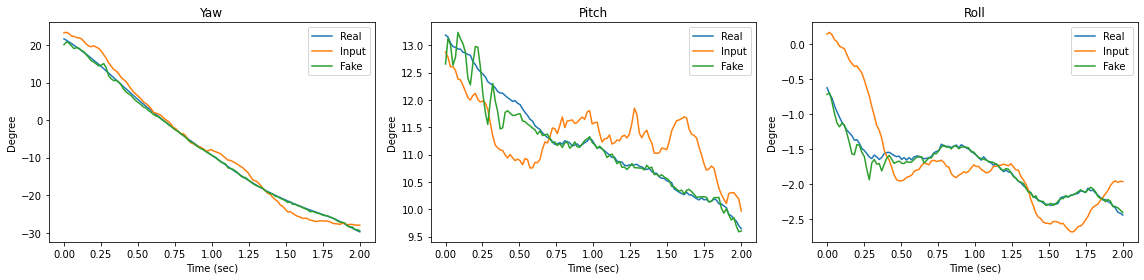

Train Epoch[701/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[701/1000] Step [01/01] d_loss: 3.2191, d_loss_real: 3.1626, d_loss_fake: 0.0565 g_loss: 0.0509 acc_real: 0.0889 acc_fake: 0.9556
Train Epoch[702/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[702/1000] Step [01/01] d_loss: 3.2168, d_loss_real: 3.2120, d_loss_fake: 0.0048 g_loss: 0.0044 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[703/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[703/1000] Step [01/01] d_loss: 3.1490, d_loss_real: 3.1447, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[704/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

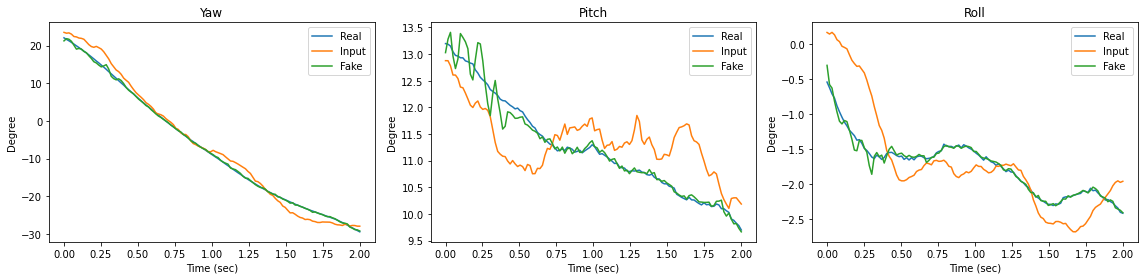

Train Epoch[711/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[711/1000] Step [01/01] d_loss: 3.3389, d_loss_real: 3.3355, d_loss_fake: 0.0034 g_loss: 0.0031 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[712/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[712/1000] Step [01/01] d_loss: 3.1434, d_loss_real: 3.1395, d_loss_fake: 0.0039 g_loss: 0.0035 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[713/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[713/1000] Step [01/01] d_loss: 2.9806, d_loss_real: 2.9748, d_loss_fake: 0.0058 g_loss: 0.0052 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[714/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

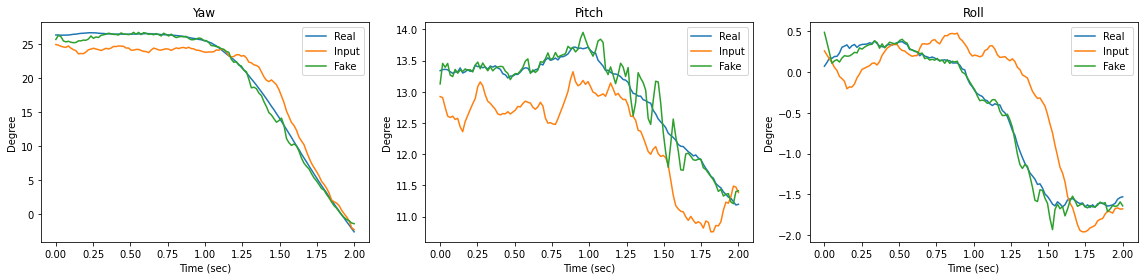

Train Epoch[721/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[721/1000] Step [01/01] d_loss: 3.0699, d_loss_real: 3.0649, d_loss_fake: 0.0050 g_loss: 0.0045 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[722/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[722/1000] Step [01/01] d_loss: 3.2105, d_loss_real: 3.2067, d_loss_fake: 0.0038 g_loss: 0.0034 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[723/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[723/1000] Step [01/01] d_loss: 3.1923, d_loss_real: 3.1873, d_loss_fake: 0.0051 g_loss: 0.0046 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[724/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

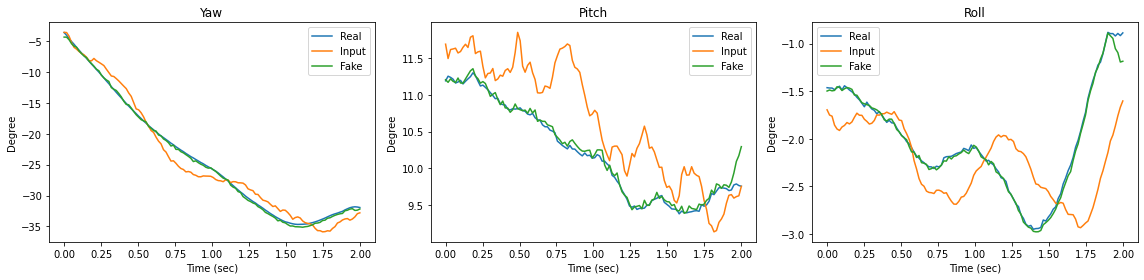

Train Epoch[731/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[731/1000] Step [01/01] d_loss: 3.3943, d_loss_real: 3.3905, d_loss_fake: 0.0038 g_loss: 0.0035 acc_real: 0.0222 acc_fake: 1.0000
Train Epoch[732/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[732/1000] Step [01/01] d_loss: 3.1729, d_loss_real: 3.1691, d_loss_fake: 0.0037 g_loss: 0.0034 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[733/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[733/1000] Step [01/01] d_loss: 3.3388, d_loss_real: 3.3356, d_loss_fake: 0.0032 g_loss: 0.0029 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[734/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

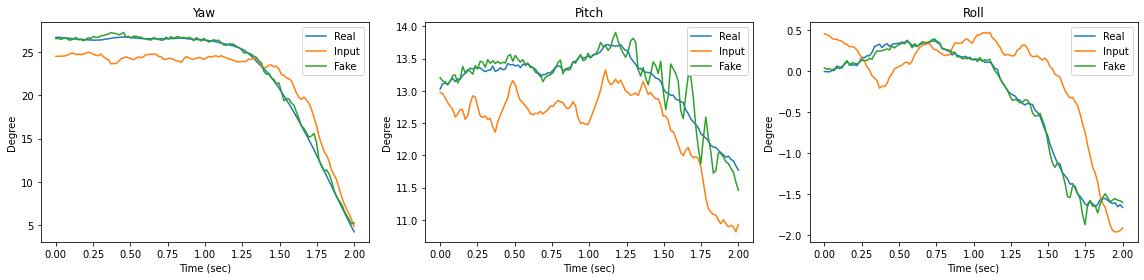

Train Epoch[741/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[741/1000] Step [01/01] d_loss: 3.0949, d_loss_real: 3.0884, d_loss_fake: 0.0065 g_loss: 0.0059 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[742/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[742/1000] Step [01/01] d_loss: 2.9772, d_loss_real: 2.9733, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[743/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[743/1000] Step [01/01] d_loss: 3.1003, d_loss_real: 3.0965, d_loss_fake: 0.0038 g_loss: 0.0034 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[744/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

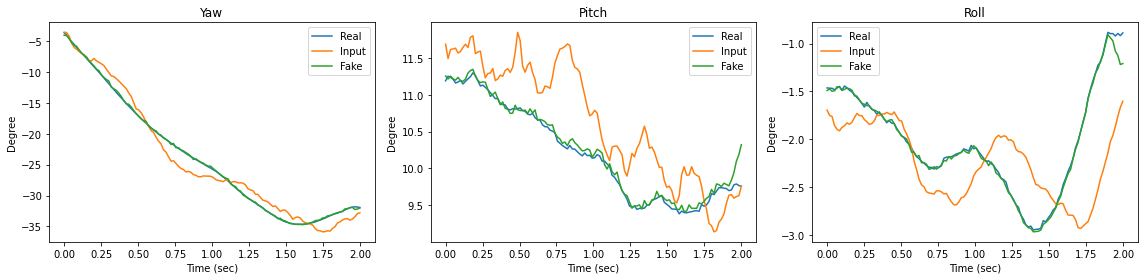

Train Epoch[751/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[751/1000] Step [01/01] d_loss: 3.3935, d_loss_real: 3.3874, d_loss_fake: 0.0061 g_loss: 0.0055 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[752/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[752/1000] Step [01/01] d_loss: 3.0859, d_loss_real: 3.0822, d_loss_fake: 0.0036 g_loss: 0.0033 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[753/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[753/1000] Step [01/01] d_loss: 3.1232, d_loss_real: 3.1188, d_loss_fake: 0.0044 g_loss: 0.0040 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[754/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

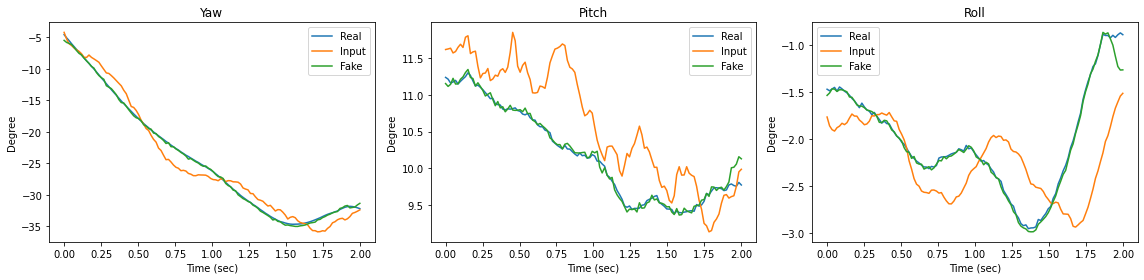

Train Epoch[761/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[761/1000] Step [01/01] d_loss: 3.3756, d_loss_real: 3.3722, d_loss_fake: 0.0034 g_loss: 0.0031 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[762/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[762/1000] Step [01/01] d_loss: 3.2603, d_loss_real: 3.2367, d_loss_fake: 0.0236 g_loss: 0.0213 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[763/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[763/1000] Step [01/01] d_loss: 3.3681, d_loss_real: 3.3648, d_loss_fake: 0.0034 g_loss: 0.0031 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[764/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

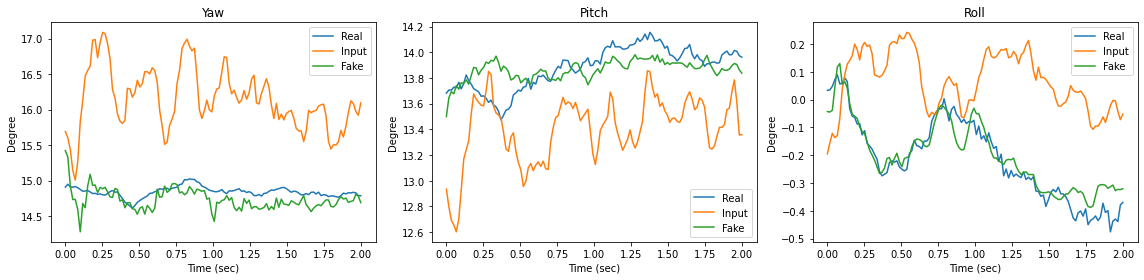

Train Epoch[771/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[771/1000] Step [01/01] d_loss: 2.7788, d_loss_real: 2.7742, d_loss_fake: 0.0046 g_loss: 0.0042 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[772/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[772/1000] Step [01/01] d_loss: 2.9376, d_loss_real: 2.9334, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[773/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[773/1000] Step [01/01] d_loss: 2.7240, d_loss_real: 2.7181, d_loss_fake: 0.0059 g_loss: 0.0053 acc_real: 0.1111 acc_fake: 1.0000
Train Epoch[774/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

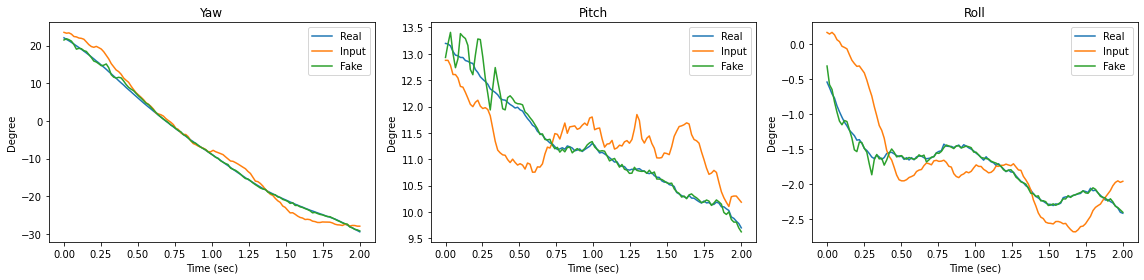

Train Epoch[781/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[781/1000] Step [01/01] d_loss: 3.1237, d_loss_real: 3.1197, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[782/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[782/1000] Step [01/01] d_loss: 2.9204, d_loss_real: 2.9159, d_loss_fake: 0.0045 g_loss: 0.0040 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[783/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[783/1000] Step [01/01] d_loss: 3.2256, d_loss_real: 3.2220, d_loss_fake: 0.0036 g_loss: 0.0032 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[784/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

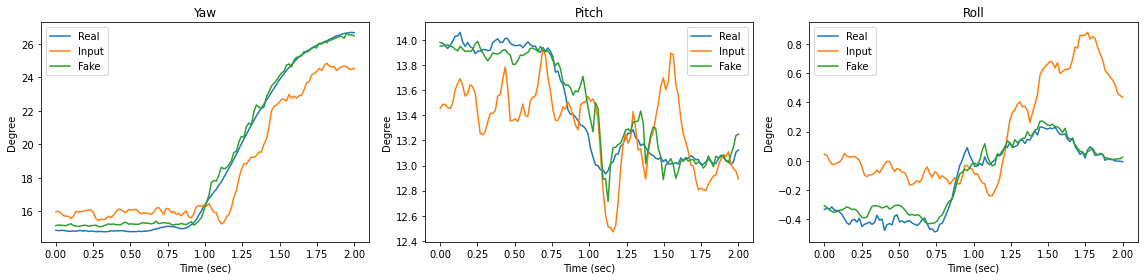

Train Epoch[791/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[791/1000] Step [01/01] d_loss: 3.0563, d_loss_real: 3.0525, d_loss_fake: 0.0037 g_loss: 0.0034 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[792/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[792/1000] Step [01/01] d_loss: 3.0105, d_loss_real: 3.0066, d_loss_fake: 0.0039 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[793/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[793/1000] Step [01/01] d_loss: 3.0501, d_loss_real: 3.0463, d_loss_fake: 0.0038 g_loss: 0.0035 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[794/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

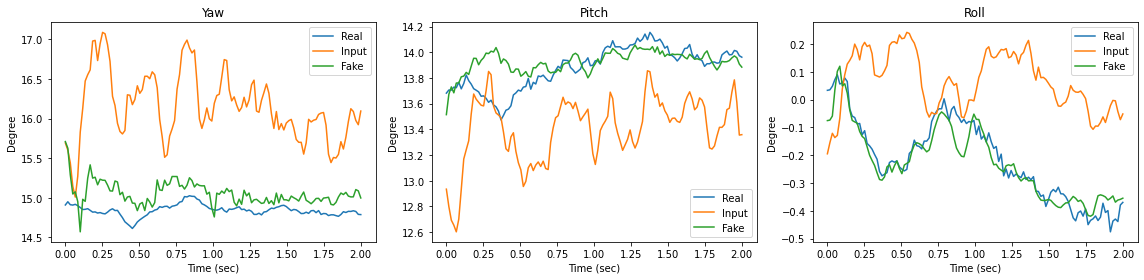

Train Epoch[801/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[801/1000] Step [01/01] d_loss: 2.9110, d_loss_real: 2.9070, d_loss_fake: 0.0041 g_loss: 0.0037 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[802/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[802/1000] Step [01/01] d_loss: 2.9990, d_loss_real: 2.9950, d_loss_fake: 0.0040 g_loss: 0.0037 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[803/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[803/1000] Step [01/01] d_loss: 3.1076, d_loss_real: 3.0391, d_loss_fake: 0.0684 g_loss: 0.0616 acc_real: 0.0889 acc_fake: 0.9333
Train Epoch[804/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

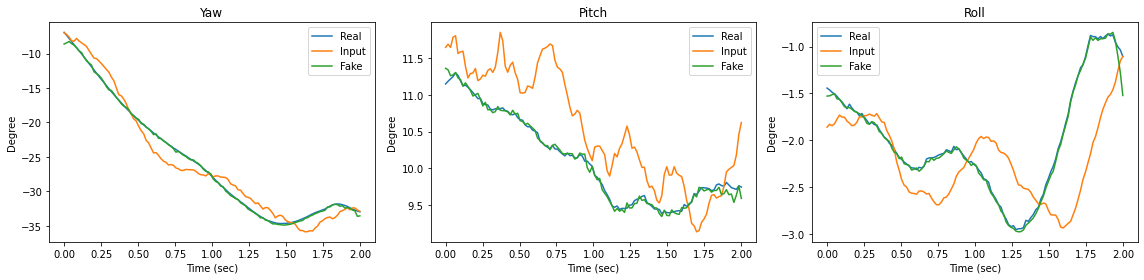

Train Epoch[811/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[811/1000] Step [01/01] d_loss: 3.0548, d_loss_real: 3.0506, d_loss_fake: 0.0041 g_loss: 0.0037 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[812/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[812/1000] Step [01/01] d_loss: 3.0845, d_loss_real: 3.0804, d_loss_fake: 0.0041 g_loss: 0.0037 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[813/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[813/1000] Step [01/01] d_loss: 3.3164, d_loss_real: 3.3122, d_loss_fake: 0.0042 g_loss: 0.0038 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[814/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

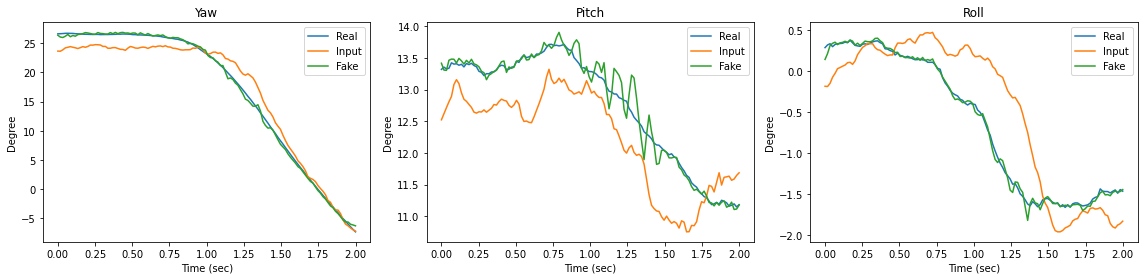

Train Epoch[821/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[821/1000] Step [01/01] d_loss: 3.0476, d_loss_real: 3.0438, d_loss_fake: 0.0038 g_loss: 0.0034 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[822/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[822/1000] Step [01/01] d_loss: 3.0422, d_loss_real: 3.0384, d_loss_fake: 0.0038 g_loss: 0.0035 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[823/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[823/1000] Step [01/01] d_loss: 3.0558, d_loss_real: 3.0520, d_loss_fake: 0.0039 g_loss: 0.0035 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[824/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

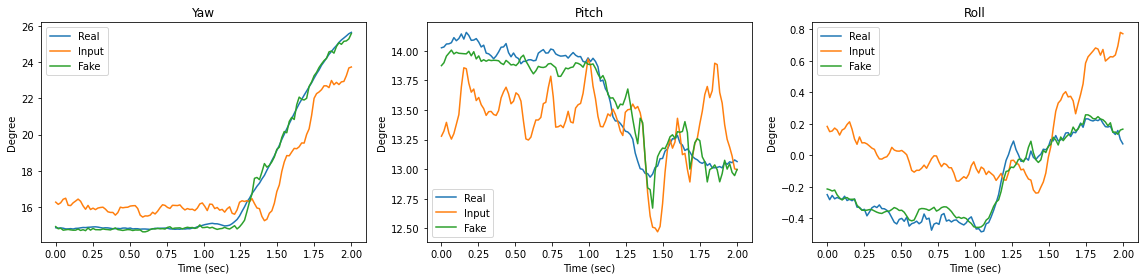

Train Epoch[831/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[831/1000] Step [01/01] d_loss: 3.0305, d_loss_real: 3.0267, d_loss_fake: 0.0038 g_loss: 0.0034 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[832/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[832/1000] Step [01/01] d_loss: 3.2226, d_loss_real: 3.2189, d_loss_fake: 0.0036 g_loss: 0.0033 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[833/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[833/1000] Step [01/01] d_loss: 3.1024, d_loss_real: 3.0987, d_loss_fake: 0.0037 g_loss: 0.0034 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[834/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

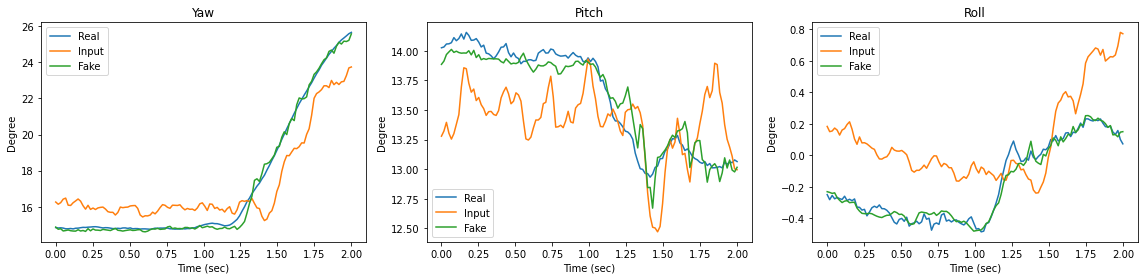

Train Epoch[841/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[841/1000] Step [01/01] d_loss: 3.0284, d_loss_real: 3.0244, d_loss_fake: 0.0040 g_loss: 0.0036 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[842/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[842/1000] Step [01/01] d_loss: 3.4377, d_loss_real: 3.4333, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[843/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[843/1000] Step [01/01] d_loss: 3.0922, d_loss_real: 3.0888, d_loss_fake: 0.0034 g_loss: 0.0031 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[844/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

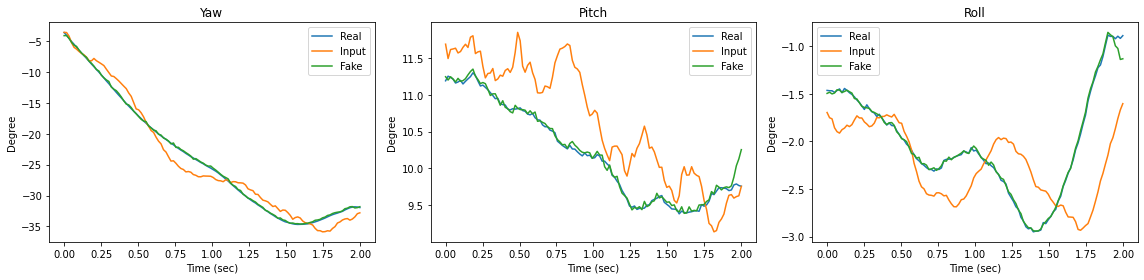

Train Epoch[851/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[851/1000] Step [01/01] d_loss: 3.1413, d_loss_real: 3.1377, d_loss_fake: 0.0036 g_loss: 0.0033 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[852/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[852/1000] Step [01/01] d_loss: 3.1075, d_loss_real: 3.0834, d_loss_fake: 0.0242 g_loss: 0.0218 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[853/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[853/1000] Step [01/01] d_loss: 3.0957, d_loss_real: 3.0919, d_loss_fake: 0.0037 g_loss: 0.0034 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[854/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

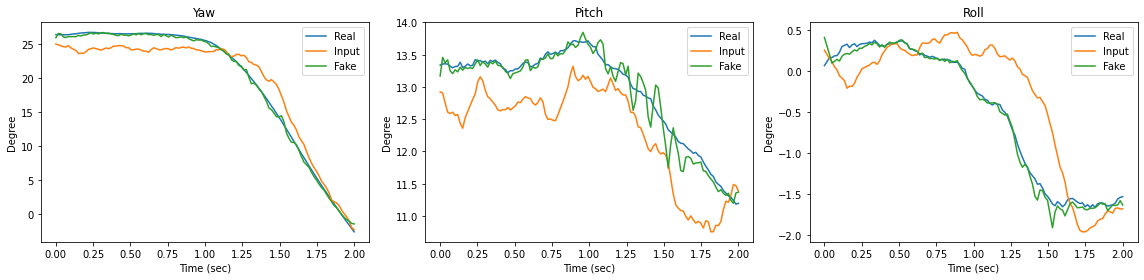

Train Epoch[861/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[861/1000] Step [01/01] d_loss: 3.0356, d_loss_real: 3.0314, d_loss_fake: 0.0042 g_loss: 0.0038 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[862/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[862/1000] Step [01/01] d_loss: 3.0579, d_loss_real: 3.0543, d_loss_fake: 0.0036 g_loss: 0.0033 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[863/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[863/1000] Step [01/01] d_loss: 3.0579, d_loss_real: 3.0542, d_loss_fake: 0.0037 g_loss: 0.0033 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[864/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

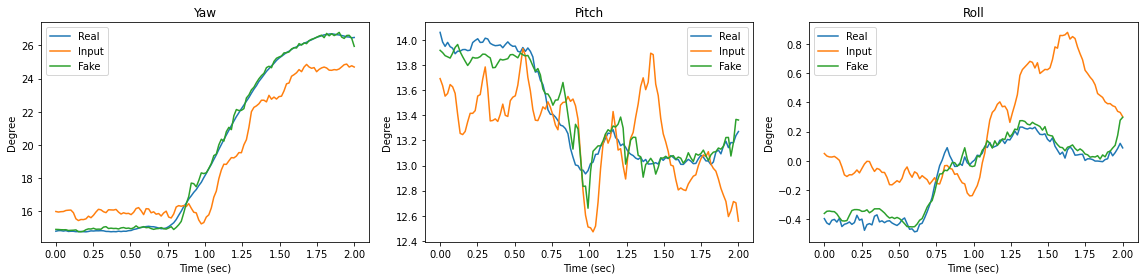

Train Epoch[871/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[871/1000] Step [01/01] d_loss: 3.2286, d_loss_real: 3.2255, d_loss_fake: 0.0031 g_loss: 0.0029 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[872/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[872/1000] Step [01/01] d_loss: 3.2569, d_loss_real: 3.2531, d_loss_fake: 0.0038 g_loss: 0.0035 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[873/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[873/1000] Step [01/01] d_loss: 3.0483, d_loss_real: 3.0445, d_loss_fake: 0.0038 g_loss: 0.0035 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[874/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

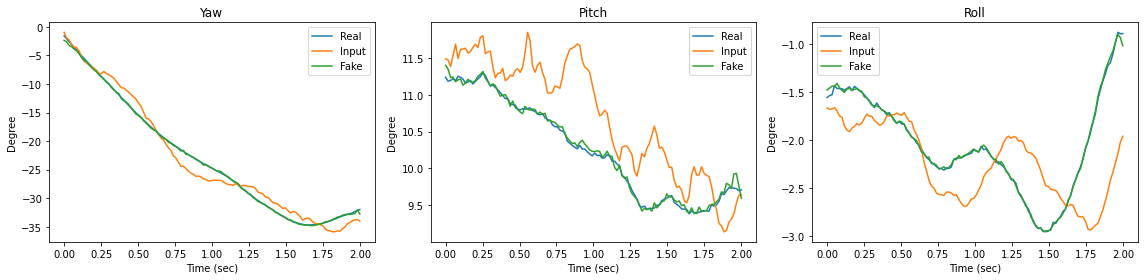

Train Epoch[881/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[881/1000] Step [01/01] d_loss: 3.2705, d_loss_real: 3.2671, d_loss_fake: 0.0034 g_loss: 0.0031 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[882/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[882/1000] Step [01/01] d_loss: 3.3896, d_loss_real: 3.3865, d_loss_fake: 0.0031 g_loss: 0.0028 acc_real: 0.0444 acc_fake: 1.0000
Train Epoch[883/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[883/1000] Step [01/01] d_loss: 3.2438, d_loss_real: 3.2403, d_loss_fake: 0.0034 g_loss: 0.0031 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[884/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

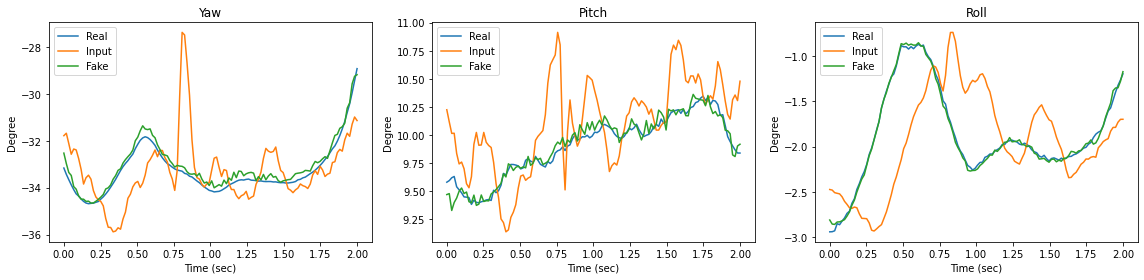

Train Epoch[891/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[891/1000] Step [01/01] d_loss: 2.9677, d_loss_real: 2.9633, d_loss_fake: 0.0044 g_loss: 0.0040 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[892/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[892/1000] Step [01/01] d_loss: 3.1858, d_loss_real: 3.1824, d_loss_fake: 0.0035 g_loss: 0.0031 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[893/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[893/1000] Step [01/01] d_loss: 3.1591, d_loss_real: 3.1285, d_loss_fake: 0.0305 g_loss: 0.0275 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[894/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

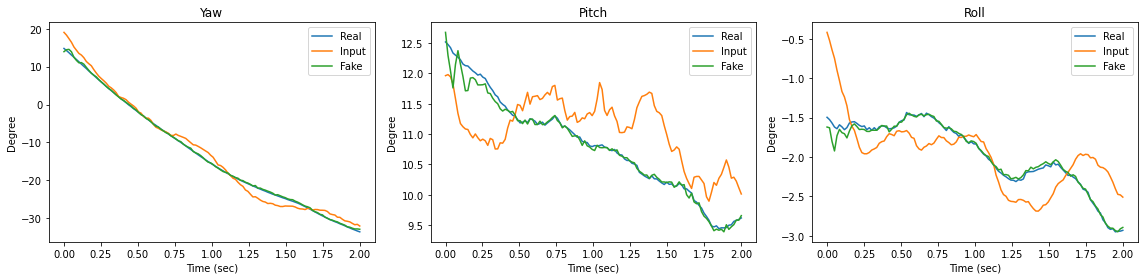

Train Epoch[901/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[901/1000] Step [01/01] d_loss: 3.2316, d_loss_real: 3.2277, d_loss_fake: 0.0039 g_loss: 0.0035 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[902/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[902/1000] Step [01/01] d_loss: 3.0345, d_loss_real: 3.0279, d_loss_fake: 0.0066 g_loss: 0.0059 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[903/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[903/1000] Step [01/01] d_loss: 3.1794, d_loss_real: 3.1752, d_loss_fake: 0.0043 g_loss: 0.0039 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[904/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

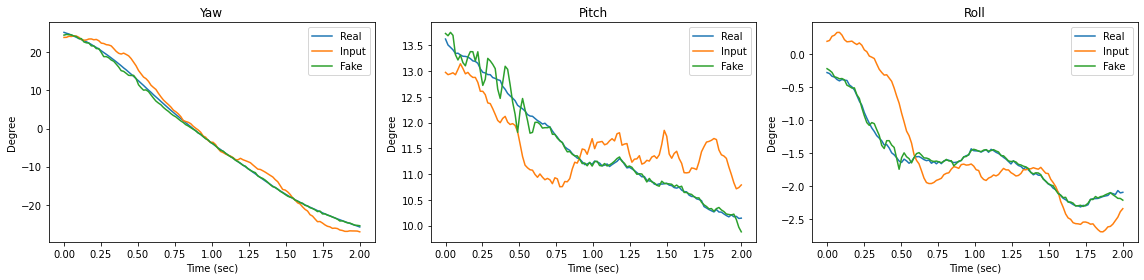

Train Epoch[911/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[911/1000] Step [01/01] d_loss: 3.0506, d_loss_real: 3.0470, d_loss_fake: 0.0037 g_loss: 0.0033 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[912/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[912/1000] Step [01/01] d_loss: 3.3994, d_loss_real: 3.3960, d_loss_fake: 0.0034 g_loss: 0.0031 acc_real: 0.0444 acc_fake: 1.0000
Train Epoch[913/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[913/1000] Step [01/01] d_loss: 3.0726, d_loss_real: 3.0659, d_loss_fake: 0.0068 g_loss: 0.0061 acc_real: 0.0889 acc_fake: 1.0000
Train Epoch[914/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.000

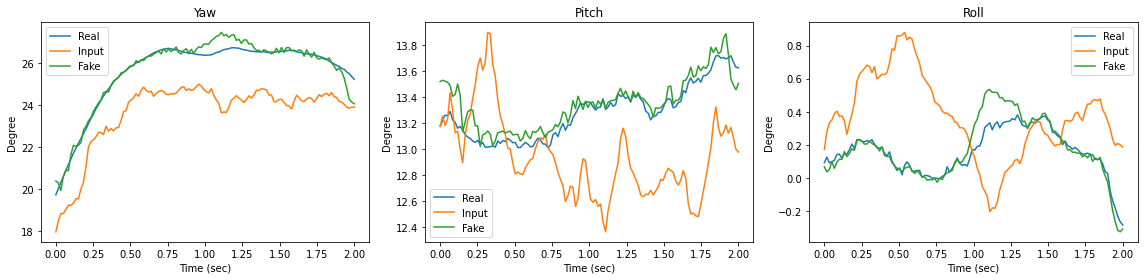

Train Epoch[921/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[921/1000] Step [01/01] d_loss: 3.6503, d_loss_real: 3.6473, d_loss_fake: 0.0030 g_loss: 0.0027 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[922/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[922/1000] Step [01/01] d_loss: 3.6508, d_loss_real: 3.6475, d_loss_fake: 0.0033 g_loss: 0.0030 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[923/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[923/1000] Step [01/01] d_loss: 3.4225, d_loss_real: 3.4181, d_loss_fake: 0.0044 g_loss: 0.0040 acc_real: 0.0444 acc_fake: 1.0000
Train Epoch[924/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

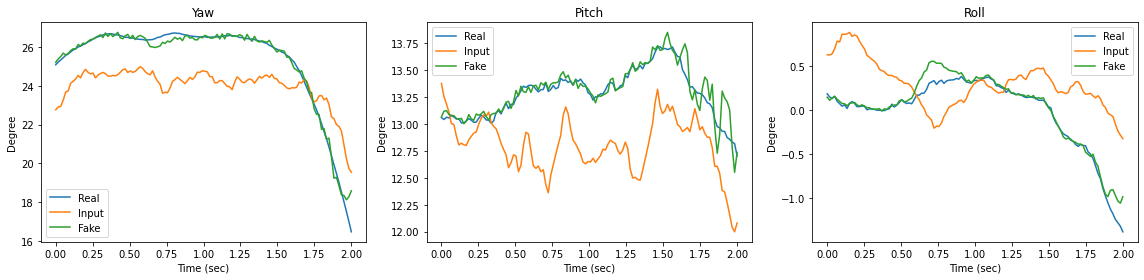

Train Epoch[931/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0000 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[931/1000] Step [01/01] d_loss: 3.6319, d_loss_real: 3.6292, d_loss_fake: 0.0027 g_loss: 0.0025 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[932/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[932/1000] Step [01/01] d_loss: 3.5682, d_loss_real: 3.5649, d_loss_fake: 0.0033 g_loss: 0.0030 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[933/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[933/1000] Step [01/01] d_loss: 3.2945, d_loss_real: 3.2891, d_loss_fake: 0.0054 g_loss: 0.0049 acc_real: 0.0667 acc_fake: 1.0000
Train Epoch[934/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0001 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

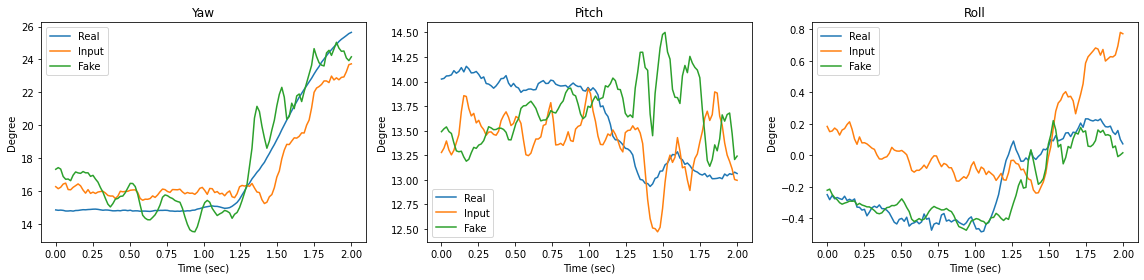

Train Epoch[941/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0021 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[941/1000] Step [01/01] d_loss: 5.2544, d_loss_real: 5.2511, d_loss_fake: 0.0033 g_loss: 0.0050 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[942/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0001 g_loss: 0.0020 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[942/1000] Step [01/01] d_loss: 5.1925, d_loss_real: 5.1871, d_loss_fake: 0.0054 g_loss: 0.0063 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[943/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0011 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[943/1000] Step [01/01] d_loss: 5.1532, d_loss_real: 5.1487, d_loss_fake: 0.0044 g_loss: 0.0055 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[944/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005 acc_real: 1.0000 acc_fake: 1.000

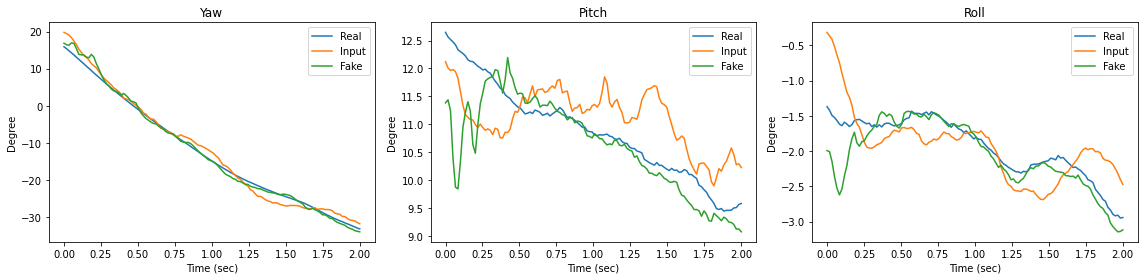

Train Epoch[951/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[951/1000] Step [01/01] d_loss: 5.1123, d_loss_real: 5.1092, d_loss_fake: 0.0031 g_loss: 0.0032 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[952/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[952/1000] Step [01/01] d_loss: 5.3208, d_loss_real: 5.3188, d_loss_fake: 0.0020 g_loss: 0.0020 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[953/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[953/1000] Step [01/01] d_loss: 5.7828, d_loss_real: 5.7808, d_loss_fake: 0.0020 g_loss: 0.0019 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[954/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

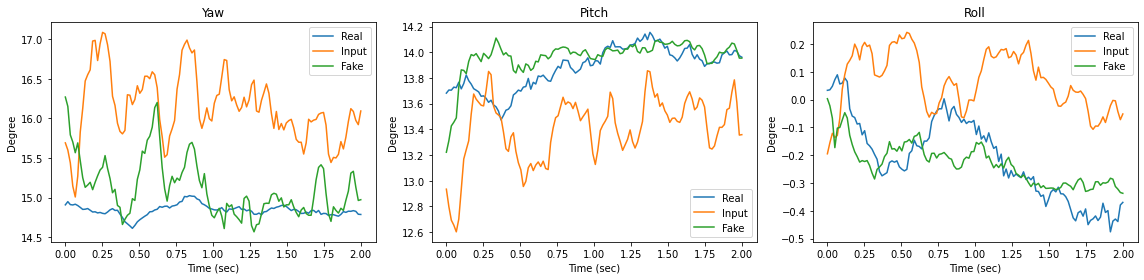

Train Epoch[961/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[961/1000] Step [01/01] d_loss: 5.4546, d_loss_real: 5.4533, d_loss_fake: 0.0014 g_loss: 0.0013 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[962/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[962/1000] Step [01/01] d_loss: 5.4847, d_loss_real: 5.4830, d_loss_fake: 0.0017 g_loss: 0.0017 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[963/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[963/1000] Step [01/01] d_loss: 5.2832, d_loss_real: 5.2815, d_loss_fake: 0.0017 g_loss: 0.0016 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[964/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004 acc_real: 1.0000 acc_fake: 1.000

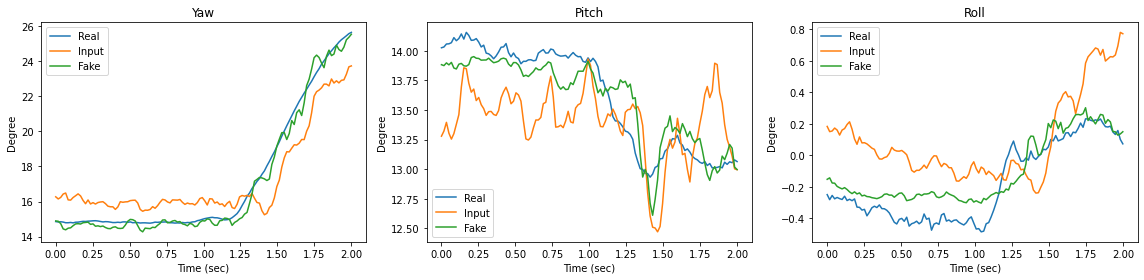

Train Epoch[971/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[971/1000] Step [01/01] d_loss: 4.4639, d_loss_real: 4.4618, d_loss_fake: 0.0021 g_loss: 0.0020 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[972/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[972/1000] Step [01/01] d_loss: 4.8823, d_loss_real: 4.8801, d_loss_fake: 0.0022 g_loss: 0.0020 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[973/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[973/1000] Step [01/01] d_loss: 4.7691, d_loss_real: 4.7666, d_loss_fake: 0.0025 g_loss: 0.0024 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[974/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

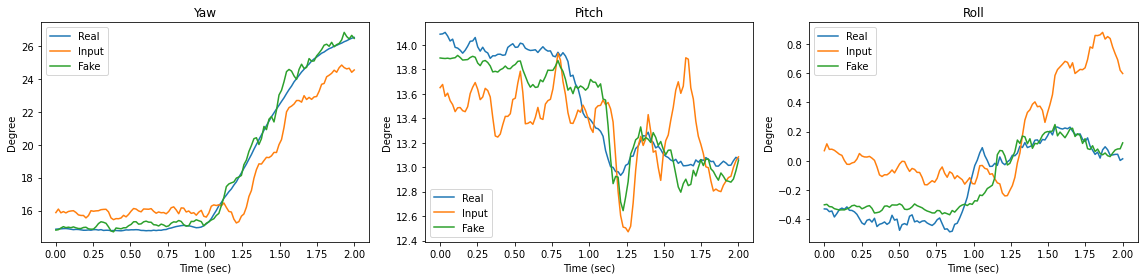

Train Epoch[981/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[981/1000] Step [01/01] d_loss: 4.5477, d_loss_real: 4.5454, d_loss_fake: 0.0023 g_loss: 0.0022 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[982/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[982/1000] Step [01/01] d_loss: 4.5510, d_loss_real: 4.5481, d_loss_fake: 0.0029 g_loss: 0.0027 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[983/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[983/1000] Step [01/01] d_loss: 4.6373, d_loss_real: 4.6347, d_loss_fake: 0.0026 g_loss: 0.0023 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[984/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.000

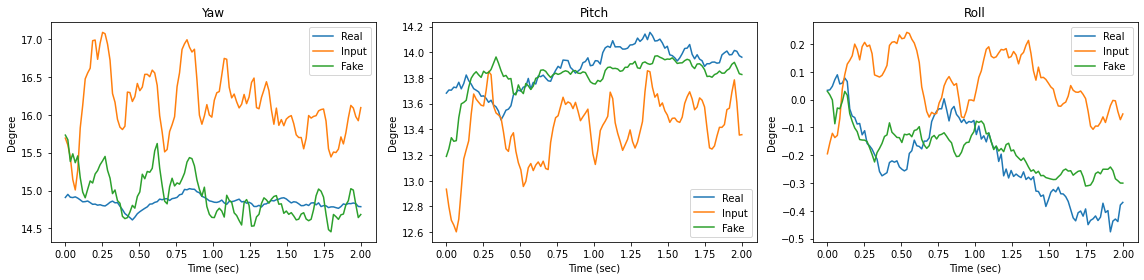

Train Epoch[991/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[991/1000] Step [01/01] d_loss: 4.8720, d_loss_real: 4.8697, d_loss_fake: 0.0023 g_loss: 0.0023 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[992/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[992/1000] Step [01/01] d_loss: 4.5300, d_loss_real: 4.5268, d_loss_fake: 0.0032 g_loss: 0.0029 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[993/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0001 acc_real: 1.0000 acc_fake: 1.0000
Validation Epoch[993/1000] Step [01/01] d_loss: 5.2027, d_loss_real: 5.2007, d_loss_fake: 0.0020 g_loss: 0.0018 acc_real: 0.0000 acc_fake: 1.0000
Train Epoch[994/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002 acc_real: 1.0000 acc_fake: 1.000

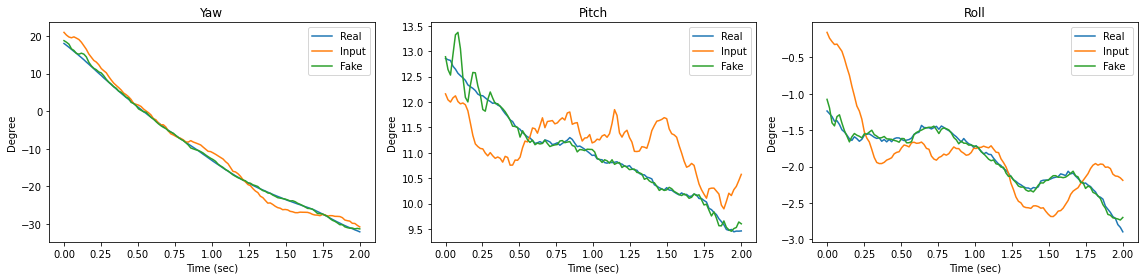

In [41]:
num_epochs = 1000

gen_weight = 0.1

for epoch in range(1, num_epochs + 1):
    # ===============================================================
    #                      Train Loop
    # ===============================================================
    G.train()
    D.train()
    total_steps = len(dl_train)
    for step, (x_real, x_fake) in enumerate(dl_train, 1):
        x_real = x_real.cuda()
        x_fake = x_fake.cuda()
        x_gen = G(x_fake)
        
        y_real = torch.ones(x_real.shape[0], 1, dtype=torch.float32).cuda()
        y_fake = torch.zeros(x_fake.shape[0], 1, dtype=torch.float32).cuda()
        
        pred_real = D(x_real)
        pred_fake = D(x_gen)
        
        d_loss_real = d_criterion(pred_real, y_real)
        d_loss_fake = d_criterion(pred_fake, y_fake)
        d_loss = (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Calculate detector accuracy, percentage of hits, 
        acc_real = ((pred_real >= 0.5) * 1).sum() / y_real.numel()
        acc_fake = ((pred_fake < 0.5) * 1).sum() / y_fake.numel()
        
        x_gen = G(x_fake)
        pred_fake = D(x_gen)
        g_loss_real = g_criterion(x_gen, x_real)
        d_loss_fake = d_criterion(pred_fake, y_fake)
        g_loss = g_loss_real * gen_weight + d_loss_fake * (1 - gen_weight)
        #g_loss = d_loss_fake
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if step == total_steps:
            print(f'Train Epoch[{epoch:03d}/{num_epochs:03d}] Step [{step:02d}/{total_steps:02d}] '
                  f'd_loss: {d_loss.item():.4f}, '
                  f'd_loss_real: {d_loss_real.item():.4f}, '
                  f'd_loss_fake: {d_loss_fake:.4f} '
                  f'g_loss: {g_loss.item():.4f} '
                  f'acc_real: {acc_real.item():.4f} '
                  f'acc_fake: {acc_fake.item():.4f}')
        
    # ===============================================================
    #                      Validation Loop
    # ===============================================================
    with torch.no_grad():
        G.eval()
        D.eval()
        total_steps = len(dl_test)
        for step, (x_real, x_fake) in enumerate(dl_test, 1):
            x_real = x_real.cuda()
            x_fake = x_fake.cuda()
            x_gen = G(x_fake)

            y_real = torch.ones(x_real.shape[0], 1, dtype=torch.float32).cuda()
            y_fake = torch.zeros(x_fake.shape[0], 1, dtype=torch.float32).cuda()

            pred_real = D(x_real)
            pred_fake = D(x_gen)

            d_loss_real = d_criterion(pred_real, y_real)
            d_loss_fake = d_criterion(pred_fake, y_fake)
            d_loss = (d_loss_real + d_loss_fake)
        
            # Calculate detector accuracy, percentage of hits, 
            acc_real = ((pred_real >= 0.5) * 1).sum() / y_real.numel()
            acc_fake = ((pred_fake < 0.5) * 1).sum() / y_fake.numel()

            x_gen = G(x_fake)
            pred_fake = D(x_gen)
            g_loss_real = g_criterion(x_gen, x_real)
            d_loss_fake = d_criterion(pred_fake, y_fake)
            g_loss = g_loss_real * gen_weight + d_loss_fake * (1 - gen_weight)
            #g_loss = d_loss_fake
            
            if step == total_steps:
                print(f'Validation Epoch[{epoch:03d}/{num_epochs:03d}] Step [{step:02d}/{total_steps:02d}] '
                      f'd_loss: {d_loss.item():.4f}, '
                      f'd_loss_real: {d_loss_real.item():.4f}, '
                      f'd_loss_fake: {d_loss_fake:.4f} '
                      f'g_loss: {g_loss.item():.4f} '
                      f'acc_real: {acc_real.item():.4f} '
                      f'acc_fake: {acc_fake.item():.4f}')

        if epoch % 10 == 0:
            plot_result()

# ds_test2에서도 결과가 잘 나오는지 확인

In [50]:
dl_test2 = DataLoader(ds_test2,  batch_size=13, num_workers=2, pin_memory=True, shuffle=True)

Validation Epoch[10000/1000] Step [01/01] d_loss: 4.9785, d_loss_real: 4.9759, d_loss_fake: 0.0026 g_loss: 0.0024 acc_real: 0.0000 acc_fake: 1.0000


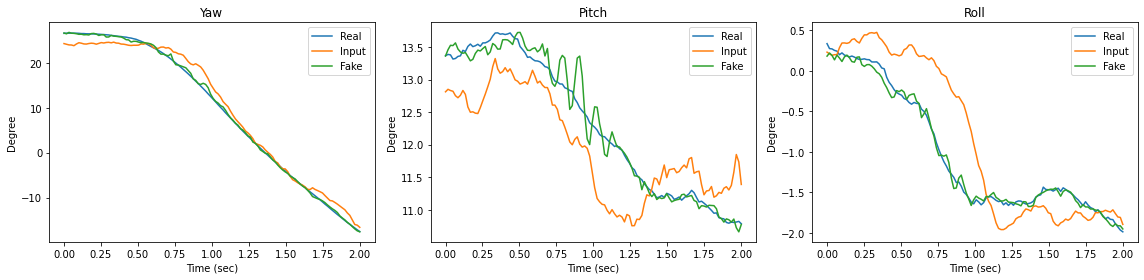

Validation Epoch[10001/1000] Step [02/01] d_loss: 4.8210, d_loss_real: 4.8186, d_loss_fake: 0.0025 g_loss: 0.0023 acc_real: 0.0000 acc_fake: 1.0000


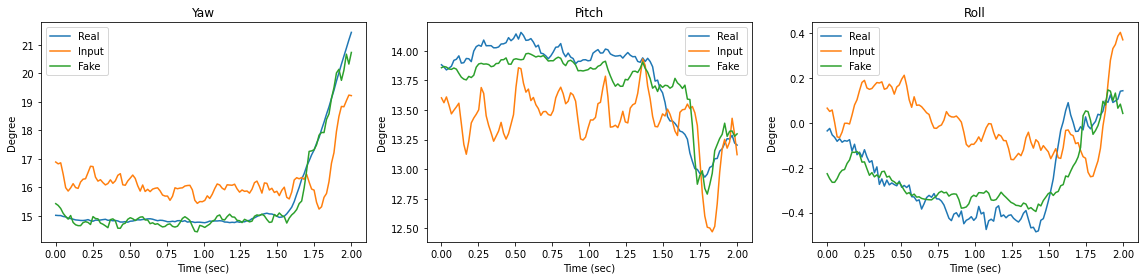

Validation Epoch[10002/1000] Step [03/01] d_loss: 4.2959, d_loss_real: 4.2939, d_loss_fake: 0.0020 g_loss: 0.0018 acc_real: 0.0000 acc_fake: 1.0000


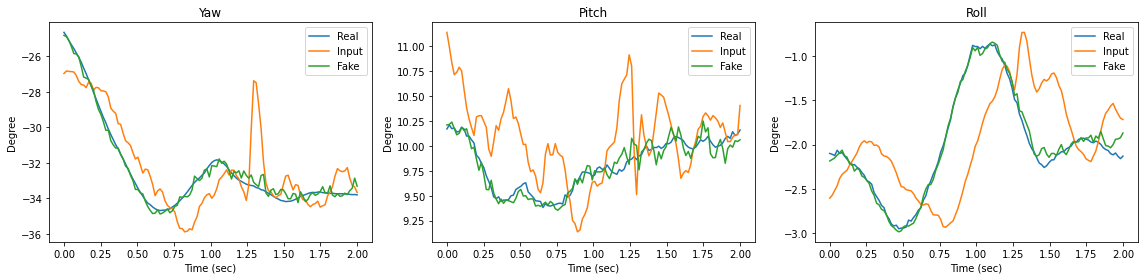

Validation Epoch[10003/1000] Step [04/01] d_loss: 4.6314, d_loss_real: 4.6283, d_loss_fake: 0.0031 g_loss: 0.0028 acc_real: 0.0000 acc_fake: 1.0000


IndexError: index 12 is out of bounds for dimension 0 with size 6

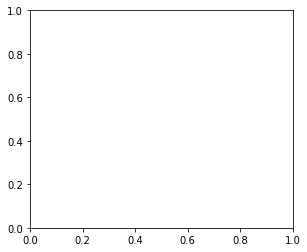

In [51]:
with torch.no_grad():
    G.eval()
    D.eval()
    
    total_steps = len(dl_test)
    epoch = 10000
    for step, (x_real, x_fake) in enumerate(dl_test2, 1):
        x_real = x_real.cuda()
        x_fake = x_fake.cuda()
        x_gen = G(x_fake)

        y_real = torch.ones(x_real.shape[0], 1, dtype=torch.float32).cuda()
        y_fake = torch.zeros(x_fake.shape[0], 1, dtype=torch.float32).cuda()

        pred_real = D(x_real)
        pred_fake = D(x_gen)

        d_loss_real = d_criterion(pred_real, y_real)
        d_loss_fake = d_criterion(pred_fake, y_fake)
        d_loss = (d_loss_real + d_loss_fake)

        # Calculate detector accuracy, percentage of hits, 
        acc_real = ((pred_real >= 0.5) * 1).sum() / y_real.numel()
        acc_fake = ((pred_fake < 0.5) * 1).sum() / y_fake.numel()

        x_gen = G(x_fake)
        pred_fake = D(x_gen)
        g_loss_real = g_criterion(x_gen, x_real)
        d_loss_fake = d_criterion(pred_fake, y_fake)
        g_loss = g_loss_real * gen_weight + d_loss_fake * (1 - gen_weight)
        #g_loss = d_loss_fake

        print(f'Validation Epoch[{epoch:03d}/{num_epochs:03d}] Step [{step:02d}/{total_steps:02d}] '
          f'd_loss: {d_loss.item():.4f}, '
          f'd_loss_real: {d_loss_real.item():.4f}, '
          f'd_loss_fake: {d_loss_fake:.4f} '
          f'g_loss: {g_loss.item():.4f} '
          f'acc_real: {acc_real.item():.4f} '
          f'acc_fake: {acc_fake.item():.4f}')

        plot_result()
        epoch += 1

# 할것

- D 모델 accuracy 구하기
- Yaw, pitch, roll RMS랑 99%tile 구하기